# 🔬 Fluor-RLAT Model Training

Train property prediction models for fluorescent molecules on Google Colab with GPU acceleration.

**Quick Start:**
1. Go to Runtime → Change runtime type → Select **T4 GPU**
2. Run all cells (Runtime → Run all)
3. The notebook will automatically clone the repository and download training data

**Models:**
- `abs` - Absorption wavelength (nm)
- `em` - Emission wavelength (nm)
- `plqy` - Photoluminescence quantum yield (0-1)
- `k` - Log molar absorptivity

**Architecture:** AttentiveFP GNN + Fingerprint CNN fusion (~2.3M parameters per model)

**Expected training time:** ~1-2 hours total on T4 GPU

---

## 1. Install Dependencies

In [1]:
# ============================================================================
# Install Dependencies FIRST (before importing torch)
# ============================================================================
# DGL requires specific PyTorch/CUDA combinations. Install everything first,
# then import and configure torch afterwards.

import os
os.environ['TORCHDYNAMO_DISABLE'] = '1'  # Set env var before any torch import

# Quick check of pre-installed CUDA version (without importing torch yet)
!nvidia-smi --query-gpu=driver_version --format=csv,noheader | head -1
cuda_version = !nvcc --version 2>/dev/null | grep -oP 'release \K[\d.]+'
cuda_ver = cuda_version[0] if cuda_version else "12"
print(f"Detected CUDA: {cuda_ver}")

# Install RDKit first (required by dgllife)
print("Installing RDKit...")
!pip install rdkit -q

# Install DGL for the appropriate CUDA version
if cuda_ver.startswith('12'):
    print("Installing DGL for CUDA 12.x + PyTorch 2.4...")
    !pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html -q
elif cuda_ver.startswith('11'):
    print("Installing DGL for CUDA 11.x...")
    !pip install dgl -f https://data.dgl.ai/wheels/torch-2.1/cu118/repo.html -q
else:
    print("Installing DGL (default for CUDA 12.x)...")
    !pip install dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html -q

# Install dgllife for molecular graph utilities
print("Installing dgllife...")
!pip install dgllife -q

# Install tqdm for progress bars
!pip install tqdm -q

print("\n✅ Dependencies installed!")
print("⚠️  If this is your first run, restart runtime now: Runtime → Restart runtime")

Detected CUDA: 12.8
Installing RDKit...
Installing DGL for CUDA 12.x + PyTorch 2.4...
Installing dgllife...

✅ Dependencies installed!
⚠️  If this is your first run, restart runtime now: Runtime → Restart runtime


In [2]:
# ============================================================================
# Import and Configure PyTorch (AFTER dependencies are installed)
# ============================================================================
import os
os.environ['TORCHDYNAMO_DISABLE'] = '1'  # Ensure set before import

import torch

# Disable dynamo to prevent version conflicts
torch._dynamo.config.suppress_errors = True
torch._dynamo.config.disable = True

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"✅ Torch dynamo disabled")

# Verify DGL installation
import dgl
print(f"DGL version: {dgl.__version__}")

# Test CUDA with DGL
if torch.cuda.is_available():
    g = dgl.graph(([0, 1], [1, 2]))
    g = g.to('cuda')
    print(f"DGL graph on CUDA: {g.device}")
    print("✅ DGL CUDA support working!")

PyTorch version: 2.4.0+cu121
CUDA available: True
CUDA version: 12.1
GPU: Tesla T4
✅ Torch dynamo disabled
DGL version: 2.4.0+cu124
DGL graph on CUDA: cuda:0
✅ DGL CUDA support working!


## 2. Mount Google Drive and Setup Directories

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create project directories
import os
os.makedirs('./data', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./checkpoints', exist_ok=True)

print("✅ Directories created")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Directories created


## 3. Clone Repository and Setup Data

Clone the fluor_tools repository directly from GitHub to access training data.

In [4]:
# Clone the repository
import os
import shutil

REPO_URL = "https://github.com/markste-in/fluor_tools.git"
REPO_DIR = "fluor_tools"

if not os.path.exists(REPO_DIR):
    print(f"📥 Cloning repository from {REPO_URL}...")
    !git clone {REPO_URL}
    print("✅ Repository cloned!")
else:
    print(f"✅ Repository already exists at {REPO_DIR}")
    # Optionally pull latest changes
    !cd {REPO_DIR} && git pull

# Data always lives in the cloned repo's data folder
DATA_DIR = f'./{REPO_DIR}/Fluor-RLAT/data'

# ============================================================================
# Check for newer merged training data on Google Drive
# ============================================================================
# The Create_Training_Data notebook deploys merged train files here.
# If found, we copy them into the repo's data dir, replacing the originals.
# The repo is temporary (cloned fresh), so overwriting is safe.
DRIVE_MERGED_DATA = "/content/drive/MyDrive/fluor_models/merged_training_data"

targets = ['abs', 'em', 'plqy', 'k']
file_types = ['', '_smiles', '_sol']  # main, smiles FP, solvent FP

if os.path.exists(DRIVE_MERGED_DATA):
    # Check which train files are available on Drive
    copied = []
    missing = []
    for target in targets:
        for ftype in file_types:
            filename = f'train{ftype}_{target}.csv'
            src = os.path.join(DRIVE_MERGED_DATA, filename)
            dst = os.path.join(DATA_DIR, filename)
            if os.path.exists(src):
                shutil.copy2(src, dst)
                copied.append(filename)
            else:
                missing.append(filename)
    
    if copied:
        print(f"🆕 Copied {len(copied)} merged training files from Google Drive into repo data!")
        for f in copied[:4]:
            print(f"   ✓ {f}")
        if len(copied) > 4:
            print(f"   ... and {len(copied) - 4} more")
    if missing:
        print(f"⚠️  {len(missing)} train files not found on Drive (using repo originals):")
        for f in missing[:3]:
            print(f"      {f}")
else:
    print(f"ℹ️  No merged training data at: {DRIVE_MERGED_DATA}")
    print(f"   Using original repository data")

print(f"\n📁 Data directory: {DATA_DIR}")

✅ Repository already exists at fluor_tools
Already up to date.
🆕 Copied 12 merged training files from Google Drive into repo data!
   ✓ train_abs.csv
   ✓ train_smiles_abs.csv
   ✓ train_sol_abs.csv
   ✓ train_em.csv
   ... and 8 more

📁 Data directory: ./fluor_tools/Fluor-RLAT/data


## 4. Verify GPU Availability

In [5]:
# Check GPU details
!nvidia-smi

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️ Using device: {device}")

if device == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    props = torch.cuda.get_device_properties(0)
    print(f"   Memory: {props.total_memory / 1e9:.1f} GB")
    print(f"   Compute capability: {props.major}.{props.minor}")
else:
    print("⚠️ No GPU detected! Training will be slow.")
    print("   Go to Runtime → Change runtime type → GPU")

Tue Feb 17 10:44:55 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P0             31W /   70W |     107MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 5. Configure Environment Variables

In [6]:
# Configure CUDA memory management to prevent OOM errors
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Set random seeds for reproducibility
import random
import numpy as np

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    # Enable TF32 for faster training on Ampere GPUs (A100)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print("✅ Environment configured")

✅ Environment configured


## 6. Load and Verify Training Data

In [7]:
# Verify data files are present

required_base = ['train', 'valid']
targets = ['abs', 'em', 'plqy', 'k']
file_types = ['', '_smiles', '_sol']

print(f"Checking data files in: {DATA_DIR}")
missing = []
found = []

for base in required_base:
    for target in targets:
        for ftype in file_types:
            filename = f'{base}{ftype}_{target}.csv'
            path = os.path.join(DATA_DIR, filename)
            if os.path.exists(path):
                size = os.path.getsize(path) / 1024 / 1024
                found.append((filename, size))
            else:
                missing.append(filename)

print(f"\n✅ Found {len(found)} files:")
for fname, size in found[:6]:
    print(f"   {fname} ({size:.1f} MB)")
if len(found) > 6:
    print(f"   ... and {len(found) - 6} more")

if missing:
    print(f"\n❌ Missing {len(missing)} files:")
    for fname in missing[:5]:
        print(f"   {fname}")
    print("\n⚠️ Please upload data before training!")
else:
    print("\n✅ All required files present!")

Checking data files in: ./fluor_tools/Fluor-RLAT/data

✅ Found 24 files:
   train_abs.csv (9.4 MB)
   train_smiles_abs.csv (43.1 MB)
   train_sol_abs.csv (43.1 MB)
   train_em.csv (7.2 MB)
   train_smiles_em.csv (33.1 MB)
   train_sol_em.csv (33.1 MB)
   ... and 18 more

✅ All required files present!


In [8]:
# Load sample counts
import pandas as pd

print("Dataset sizes:")
for target in ['abs', 'em', 'plqy', 'k']:
    train_path = os.path.join(DATA_DIR, f'train_{target}.csv')
    valid_path = os.path.join(DATA_DIR, f'valid_{target}.csv')
    
    if os.path.exists(train_path) and os.path.exists(valid_path):
        train_df = pd.read_csv(train_path)
        valid_df = pd.read_csv(valid_path)
        print(f"  {target.upper()}: {len(train_df):,} train / {len(valid_df):,} valid")

Dataset sizes:
  ABS: 22,062 train / 3,132 valid
  EM: 16,945 train / 2,370 valid
  PLQY: 13,008 train / 1,855 valid
  K: 7,050 train / 952 valid


## 7. Initialize Model Architecture

Define the complete model architecture including:
- AttentiveFP Graph Neural Network
- Fingerprint CNN with attention (for abs/em)
- Simple FC network (for plqy/k)

In [9]:
# Import all required libraries
import copy
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Use tqdm.auto which automatically selects the right backend
# Falls back to text mode if notebook widgets aren't available
from tqdm.auto import tqdm

import dgl
from dgllife.model.gnn import AttentiveFPGNN
from dgllife.model.readout import AttentiveFPReadout
from dgllife.utils import (
    smiles_to_bigraph,
    AttentiveFPAtomFeaturizer,
    AttentiveFPBondFeaturizer,
)

print("✅ All imports successful")

✅ All imports successful


In [10]:
# ============================================================================
# Configuration
# ============================================================================

BATCH_SIZE = 32
LEARNING_RATE = 5e-4  # Reduced from 1e-3 for more stable training
GRAPH_FEAT_SIZE = 256

# Learning rate scheduler settings
USE_LR_SCHEDULER = True   # Set to False to disable scheduler
LR_SCHEDULER_FACTOR = 0.5  # Reduce LR by this factor when plateau
LR_SCHEDULER_PATIENCE = 10  # Epochs to wait before reducing LR
LR_SCHEDULER_MIN = 1e-6   # Minimum learning rate

# Model configurations per target (MATCHES pretrained model parameters)
# Verified from 02_property_prediction.py source code
MODEL_CONFIGS = {
    'abs': {
        'num_layers': 2,
        'num_timesteps': 2,
        'dropout': 0.3,
        'alpha': 0.1,  # LDS alpha
        'model_class': 'GraphFingerprintsModel',  # CNN attention + solvent extractor
    },
    'em': {
        'num_layers': 3,
        'num_timesteps': 1,
        'dropout': 0.3,
        'alpha': 0.0,
        'model_class': 'GraphFingerprintsModel',
    },
    'plqy': {
        'num_layers': 2,
        'num_timesteps': 3,
        'dropout': 0.4,
        'alpha': 0.2,
        'model_class': 'GraphFingerprintsModelFC',  # Simple FC for all fingerprints
    },
    'k': {
        'num_layers': 3,
        'num_timesteps': 1,
        'dropout': 0.3,
        'alpha': 0.6,
        'model_class': 'GraphFingerprintsModelFC',
    },
}

# Featurizers for molecular graphs
ATOM_FEATURIZER = AttentiveFPAtomFeaturizer(atom_data_field='hv')
BOND_FEATURIZER = AttentiveFPBondFeaturizer(bond_data_field='he')

print("✅ Configuration loaded")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   LR scheduler: {'Enabled' if USE_LR_SCHEDULER else 'Disabled'}")
if USE_LR_SCHEDULER:
    print(f"      Factor: {LR_SCHEDULER_FACTOR}, Patience: {LR_SCHEDULER_PATIENCE}, Min LR: {LR_SCHEDULER_MIN}")
print("   abs/em: GraphFingerprintsModel (num_layers=2/3, num_timesteps=2/1)")
print("   plqy/k: GraphFingerprintsModelFC (num_layers=2/3, num_timesteps=3/1)")

✅ Configuration loaded
   Learning rate: 0.0005
   LR scheduler: Enabled
      Factor: 0.5, Patience: 10, Min LR: 1e-06
   abs/em: GraphFingerprintsModel (num_layers=2/3, num_timesteps=2/1)
   plqy/k: GraphFingerprintsModelFC (num_layers=2/3, num_timesteps=3/1)


In [11]:
# ============================================================================
# Model Architecture Classes
# ============================================================================
# These MUST match the original architecture in 02_property_prediction.py
# to ensure compatibility with pretrained models and consistent results.
#
# VERIFIED against pretrained model state_dicts:
# - Model_abs.pth, Model_em.pth: use fp_extractor + solvent_extractor
# - Model_plqy.pth, Model_k.pth: use fp_fc only (no solvent split)

class FingerprintAttentionCNN(nn.Module):
    """CNN with attention for fingerprint processing (used by abs/em models).
    
    Layer names must match: fp_extractor.conv_feat, fp_extractor.conv_attn
    Output: 2 * conv_channels (512 when conv_channels=256)
    """
    
    def __init__(self, input_dim, conv_channels=256):
        super().__init__()
        self.conv_feat = nn.Conv1d(1, conv_channels, kernel_size=3, padding=1)
        self.conv_attn = nn.Conv1d(1, conv_channels, kernel_size=3, padding=1)
        self.softmax = nn.Softmax(dim=-1)
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):
        x = x.unsqueeze(1)  # [B, 1, D]
        feat_map = self.conv_feat(x)         # [B, C, D]
        attn_map = self.conv_attn(x)         # [B, C, D]
        attn_weights = self.softmax(attn_map)
        attn_out = torch.sum(feat_map * attn_weights, dim=-1)  # [B, C]
        pooled = self.pool(feat_map).squeeze(-1)               # [B, C]
        return torch.cat([attn_out, pooled], dim=1)            # [B, 2C]


class GraphFingerprintsModel(nn.Module):
    """Model for abs/em: AttentiveFP GNN + CNN attention for fingerprints.
    
    This is the ORIGINAL class name from 02_property_prediction.py.
    Used for absorption and emission prediction.
    
    Layer names verified against Model_abs.pth / Model_em.pth:
    - gnn.*, readout.*: AttentiveFP layers
    - fp_extractor.conv_feat, fp_extractor.conv_attn: CNN attention
    - solvent_extractor.0, solvent_extractor.3: FC for solvent (1024->256->256)
    - predict.1, predict.3: final prediction (1024->128->1)
    """
    
    def __init__(self, node_feat_size, edge_feat_size, solvent_dim, smiles_extra_dim,
                 graph_feat_size=256, num_layers=2, num_timesteps=2, n_tasks=1, dropout=0.3):
        super().__init__()
        
        self.solvent_dim = solvent_dim
        
        # GNN
        self.gnn = AttentiveFPGNN(
            node_feat_size=node_feat_size,
            edge_feat_size=edge_feat_size,
            num_layers=num_layers,
            graph_feat_size=graph_feat_size,
            dropout=dropout
        )
        
        self.readout = AttentiveFPReadout(
            feat_size=graph_feat_size,
            num_timesteps=num_timesteps,
            dropout=dropout
        )
        
        # Fingerprint part: smiles + extra -> CNN attention -> 2*graph_feat_size
        self.fp_extractor = FingerprintAttentionCNN(smiles_extra_dim, conv_channels=graph_feat_size)
        
        # Fingerprint part: solvent -> FC -> graph_feat_size
        # Original: nn.Linear(solvent_dim, 256), ReLU, Dropout, nn.Linear(256, graph_feat_size)
        self.solvent_extractor = nn.Sequential(
            nn.Linear(solvent_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, graph_feat_size)
        )
        
        # Prediction: graph(256) + solvent(256) + fp(512) = 1024 -> 128 -> 1
        self.predict = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(graph_feat_size * 4, 128),  # 1024
            nn.ReLU(),
            nn.Linear(128, n_tasks)
        )
        
    def forward(self, graph, node_feats, edge_feats, fingerprints):
        node_out = self.gnn(graph, node_feats, edge_feats)
        graph_out = self.readout(graph, node_out, False)
        
        solvent_feat = fingerprints[:, :self.solvent_dim]
        smiles_extra_feat = fingerprints[:, self.solvent_dim:]
        
        solvent_out = self.solvent_extractor(solvent_feat)
        smiles_extra_out = self.fp_extractor(smiles_extra_feat)
        
        combined = torch.cat([graph_out, solvent_out, smiles_extra_out], dim=1)
        return self.predict(combined)


class GraphFingerprintsModelFC(nn.Module):
    """Model for plqy/k: AttentiveFP GNN + Simple FC for fingerprints.
    
    This uses a different architecture from abs/em - processes ALL fingerprints
    together through a simple FC, no separate solvent extractor.
    
    Layer names verified against Model_plqy.pth / Model_k.pth:
    - gnn.*, readout.*: AttentiveFP layers
    - fp_fc.0, fp_fc.3: FC for all fingerprints (2192->256->256)
    - predict.1, predict.3: final prediction (512->128->1)
    """
    
    def __init__(self, node_feat_size, edge_feat_size, fp_size,
                 graph_feat_size=256, num_layers=2, num_timesteps=2, n_tasks=1, dropout=0.3):
        super().__init__()
        
        # GNN
        self.gnn = AttentiveFPGNN(
            node_feat_size=node_feat_size,
            edge_feat_size=edge_feat_size,
            num_layers=num_layers,
            graph_feat_size=graph_feat_size,
            dropout=dropout
        )
        
        self.readout = AttentiveFPReadout(
            feat_size=graph_feat_size,
            num_timesteps=num_timesteps,
            dropout=dropout
        )
        
        # FC for ALL fingerprints -> graph_feat_size
        # Original: Linear(fp_size, 256), ReLU, Dropout, Linear(256, graph_feat_size)
        # Indices: 0=Linear, 1=ReLU, 2=Dropout, 3=Linear
        self.fp_fc = nn.Sequential(
            nn.Linear(fp_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, graph_feat_size)
        )
        
        # Prediction: graph(256) + fp(256) = 512 -> 128 -> 1
        self.predict = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(graph_feat_size * 2, 128),  # 512
            nn.ReLU(),
            nn.Linear(128, n_tasks)
        )
        
    def forward(self, graph, node_feats, edge_feats, fingerprints):
        node_out = self.gnn(graph, node_feats, edge_feats)
        graph_out = self.readout(graph, node_out, False)
        fp_out = self.fp_fc(fingerprints)
        combined = torch.cat([graph_out, fp_out], dim=1)
        return self.predict(combined)


# Aliases to match different naming conventions
GraphFingerprintsModelAttentionCNN = GraphFingerprintsModel  # for abs/em
GraphFingerprintsModelSimpleFC = GraphFingerprintsModelFC     # for plqy/k

print("✅ Model classes defined (matching original 02_property_prediction.py)")
print("   - GraphFingerprintsModel (alias: GraphFingerprintsModelAttentionCNN): for abs/em")
print("   - GraphFingerprintsModelFC (alias: GraphFingerprintsModelSimpleFC): for plqy/k")
print("")
print("   Architecture summary:")
print("   abs/em:  fp_extractor (CNN) + solvent_extractor (FC) -> predict(1024->128->1)")
print("   plqy/k:  fp_fc (FC, all fingerprints combined) -> predict(512->128->1)")

✅ Model classes defined (matching original 02_property_prediction.py)
   - GraphFingerprintsModel (alias: GraphFingerprintsModelAttentionCNN): for abs/em
   - GraphFingerprintsModelFC (alias: GraphFingerprintsModelSimpleFC): for plqy/k

   Architecture summary:
   abs/em:  fp_extractor (CNN) + solvent_extractor (FC) -> predict(1024->128->1)
   plqy/k:  fp_fc (FC, all fingerprints combined) -> predict(512->128->1)


In [12]:
# ============================================================================
# Model Configs for Original Pretrained Models
# ============================================================================
# Verified hyperparameters from 02_property_prediction.py:
#
# abs:  num_layers=2, num_timesteps=2, dropout=0.3, alpha=0.1
# em:   num_layers=3, num_timesteps=1, dropout=0.3, alpha=0.0  
# plqy: num_layers=2, num_timesteps=3, dropout=0.4, alpha=0.2
# k:    num_layers=3, num_timesteps=1, dropout=0.3, alpha=0.6

ORIGINAL_MODEL_CONFIGS = {
    'abs':  {'num_layers': 2, 'num_timesteps': 2, 'dropout': 0.3, 'alpha': 0.1, 'model_class': 'GraphFingerprintsModel'},
    'em':   {'num_layers': 3, 'num_timesteps': 1, 'dropout': 0.3, 'alpha': 0.0, 'model_class': 'GraphFingerprintsModel'},
    'plqy': {'num_layers': 2, 'num_timesteps': 3, 'dropout': 0.4, 'alpha': 0.2, 'model_class': 'GraphFingerprintsModelFC'},
    'k':    {'num_layers': 3, 'num_timesteps': 1, 'dropout': 0.3, 'alpha': 0.6, 'model_class': 'GraphFingerprintsModelFC'},
}

print("✅ Original model configs defined")
print("   abs/em use GraphFingerprintsModel (CNN attention + solvent extractor)")
print("   plqy/k use GraphFingerprintsModelFC (simple FC for all fingerprints)")

✅ Original model configs defined
   abs/em use GraphFingerprintsModel (CNN attention + solvent extractor)
   plqy/k use GraphFingerprintsModelFC (simple FC for all fingerprints)


In [13]:
# ============================================================================
# Dataset and Data Loading
# ============================================================================

class MolecularDataset(Dataset):
    """Dataset for molecular property prediction."""
    
    def __init__(self, graphs, fingerprints, labels, masks=None, weights=None):
        self.graphs = graphs
        self.fingerprints = fingerprints
        self.labels = labels
        self.masks = masks
        self.weights = weights
        
    def __len__(self):
        return len(self.graphs)
    
    def __getitem__(self, idx):
        return (
            self.graphs[idx],
            self.fingerprints[idx],
            self.labels[idx],
            self.masks[idx] if self.masks is not None else 1.0,
            self.weights[idx] if self.weights is not None else 1.0
        )


def collate_fn(batch):
    """Custom collate function for batching molecular graphs."""
    graphs, fps, labels, masks, weights = zip(*batch)
    batched_graph = dgl.batch(graphs)
    fps = torch.stack(fps)
    labels = torch.stack(labels)
    masks = torch.tensor(masks, dtype=torch.float32) if masks[0] is not None else None
    weights = torch.tensor(weights, dtype=torch.float32) if weights[0] is not None else None
    return batched_graph, fps, labels, masks, weights


def compute_lds_weights(labels, alpha=0.5, kernel_size=5):
    """Compute Label Distribution Smoothing weights."""
    if alpha == 0:
        return np.ones(len(labels))
    
    n_bins = 100
    label_min, label_max = labels.min(), labels.max()
    bins = np.linspace(label_min, label_max, n_bins + 1)
    bin_indices = np.digitize(labels, bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    bin_counts = np.bincount(bin_indices, minlength=n_bins).astype(float)
    kernel = np.ones(kernel_size) / kernel_size
    smoothed_counts = np.convolve(bin_counts, kernel, mode='same')
    smoothed_counts = np.maximum(smoothed_counts, 1)
    
    effective_counts = bin_counts ** alpha * smoothed_counts ** (1 - alpha)
    effective_counts = np.maximum(effective_counts, 1)
    
    weights = 1.0 / effective_counts[bin_indices]
    weights = weights / weights.mean()
    
    return weights.astype(np.float32)


def smiles_to_graph(smiles):
    """Convert SMILES to DGL graph with AttentiveFP featurization."""
    try:
        graph = smiles_to_bigraph(
            smiles,
            node_featurizer=ATOM_FEATURIZER,
            edge_featurizer=BOND_FEATURIZER,
            add_self_loop=False
        )
        return graph
    except Exception as e:
        return None


print("✅ Dataset classes defined")

✅ Dataset classes defined


In [24]:
# ============================================================================
# Data Loading Functions
# ============================================================================

def load_and_process_data(target, data_dir, config):
    """Load and process training/validation data for a target property."""
    
    data_dir = Path(data_dir)
    
    # Load main data files
    train_df = pd.read_csv(data_dir / f'train_{target}.csv')
    valid_df = pd.read_csv(data_dir / f'valid_{target}.csv')
    
    # Load fingerprint files
    train_smiles_fp = pd.read_csv(data_dir / f'train_smiles_{target}.csv')
    train_sol_fp = pd.read_csv(data_dir / f'train_sol_{target}.csv')
    valid_smiles_fp = pd.read_csv(data_dir / f'valid_smiles_{target}.csv')
    valid_sol_fp = pd.read_csv(data_dir / f'valid_sol_{target}.csv')
    
    print(f"   Train samples: {len(train_df)}")
    print(f"   Valid samples: {len(valid_df)}")
    
    # Extract labels
    train_labels = train_df[target].values.reshape(-1, 1).astype(np.float32)
    valid_labels = valid_df[target].values.reshape(-1, 1).astype(np.float32)
    
    # Normalize labels
    scaler = StandardScaler()
    train_labels_scaled = scaler.fit_transform(train_labels)
    valid_labels_scaled = scaler.transform(valid_labels)
    
    # Extract and normalize numeric features
    numeric_cols = train_df.columns[8:16].tolist() if len(train_df.columns) > 16 else []
    
    scaler_num = MinMaxScaler()
    if numeric_cols:
        train_numeric = scaler_num.fit_transform(train_df[numeric_cols].values)
        valid_numeric = scaler_num.transform(valid_df[numeric_cols].values)
    else:
        train_numeric = np.zeros((len(train_df), 0))
        valid_numeric = np.zeros((len(valid_df), 0))
    
    # Combine fingerprints
    train_sol = train_sol_fp.values.astype(np.float32)
    train_smiles = train_smiles_fp.values.astype(np.float32)
    valid_sol = valid_sol_fp.values.astype(np.float32)
    valid_smiles = valid_smiles_fp.values.astype(np.float32)
    
    # Get scaffold flags if present
    scaffold_cols = [c for c in train_df.columns if c.startswith('fragment_')]
    if scaffold_cols:
        train_scaffold = train_df[scaffold_cols].values.astype(np.float32)
        valid_scaffold = valid_df[scaffold_cols].values.astype(np.float32)
    else:
        train_scaffold = np.zeros((len(train_df), 0), dtype=np.float32)
        valid_scaffold = np.zeros((len(valid_df), 0), dtype=np.float32)
    
    # Combine all features
    train_fp = np.hstack([train_sol, train_smiles, train_numeric, train_scaffold])
    valid_fp = np.hstack([valid_sol, valid_smiles, valid_numeric, valid_scaffold])
    
    solvent_dim = train_sol.shape[1]
    smiles_extra_dim = train_fp.shape[1] - solvent_dim
    fp_size = train_fp.shape[1]
    
    print(f"   Total fingerprint dimensions: {fp_size}")
    
    # Compute LDS weights
    alpha = config['alpha']
    train_weights = compute_lds_weights(train_labels.flatten(), alpha=alpha)
    print(f"   LDS alpha: {alpha}, weight range: [{train_weights.min():.2f}, {train_weights.max():.2f}]")
    
    # Convert SMILES to graphs
    print("   Converting SMILES to graphs...")
    
    train_smiles_list = train_df['smiles'].tolist()
    valid_smiles_list = valid_df['smiles'].tolist()
    
    train_graphs = []
    for smi in tqdm(train_smiles_list, desc="   Train graphs", leave=False):
        g = smiles_to_graph(smi)
        if g is None:
            g = dgl.graph(([0], [0]))
            g.ndata['hv'] = torch.zeros(1, 39)
            g.edata['he'] = torch.zeros(1, 10)
        train_graphs.append(g)
    
    valid_graphs = []
    for smi in tqdm(valid_smiles_list, desc="   Valid graphs", leave=False):
        g = smiles_to_graph(smi)
        if g is None:
            g = dgl.graph(([0], [0]))
            g.ndata['hv'] = torch.zeros(1, 39)
            g.edata['he'] = torch.zeros(1, 10)
        valid_graphs.append(g)
    
    print(f"   ✅ Converted {len(train_graphs)} train + {len(valid_graphs)} valid graphs")
    
    # Create datasets
    train_data = MolecularDataset(
        graphs=train_graphs,
        fingerprints=torch.tensor(train_fp, dtype=torch.float32),
        labels=torch.tensor(train_labels_scaled, dtype=torch.float32),
        masks=None,
        weights=train_weights
    )
    
    valid_data = MolecularDataset(
        graphs=valid_graphs,
        fingerprints=torch.tensor(valid_fp, dtype=torch.float32),
        labels=torch.tensor(valid_labels_scaled, dtype=torch.float32),
        masks=None,
        weights=None
    )
    
    return {
        'train_data': train_data,
        'valid_data': valid_data,
        'scaler': scaler,
        'scaler_num': scaler_num,
        'config': config,
        'solvent_dim': solvent_dim,
        'smiles_extra_dim': smiles_extra_dim,
        'fp_size': fp_size,
    }


print("✅ Data loading functions defined")

✅ Data loading functions defined


In [25]:
# ============================================================================
# Training Functions
# ============================================================================

def train_epoch(model, dataloader, optimizer, criterion, device, use_lds=True):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    num_batches = 0
    
    for batch in dataloader:
        graphs, fps, labels, masks, weights = batch
        
        graphs = graphs.to(device)
        fps = fps.to(device)
        labels = labels.to(device)
        
        node_feats = graphs.ndata['hv']
        edge_feats = graphs.edata.get('he', None)
        
        optimizer.zero_grad()
        predictions = model(graphs, node_feats, edge_feats, fps)
        
        if use_lds and weights is not None:
            weights = weights.to(device)
            loss = (criterion(predictions, labels) * weights.unsqueeze(1)).mean()
        else:
            loss = criterion(predictions, labels).mean()
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches


def validate(model, dataloader, criterion, device):
    """Validate model on validation set."""
    model.eval()
    total_loss = 0
    num_batches = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            graphs, fps, labels, masks, _ = batch
            
            graphs = graphs.to(device)
            fps = fps.to(device)
            labels = labels.to(device)
            
            node_feats = graphs.ndata['hv']
            edge_feats = graphs.edata.get('he', None)
            
            predictions = model(graphs, node_feats, edge_feats, fps)
            loss = criterion(predictions, labels).mean()
            
            total_loss += loss.item()
            num_batches += 1
            
            all_preds.append(predictions.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.vstack(all_preds)
    all_labels = np.vstack(all_labels)
    
    return total_loss / num_batches, all_preds, all_labels


print("✅ Training functions defined")

✅ Training functions defined


## 8. Run Training Loop

In [26]:
# ============================================================================
# Main Training Function with Checkpoint Resumption
# ============================================================================

def find_checkpoint(checkpoint_dir, target):
    """Check if a checkpoint exists for the given target."""
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{target}.pth')
    if os.path.exists(checkpoint_path):
        return checkpoint_path
    return None


def check_checkpoint_status(checkpoint_path, epochs, patience):
    """Check if training is already complete without loading full checkpoint into model."""
    if not checkpoint_path:
        return None
    
    try:
        ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        epoch = ckpt.get('epoch', 0)
        epochs_without_improvement = ckpt.get('epochs_without_improvement', 0)
        best_val_loss = ckpt.get('best_val_loss', float('inf'))
        history = ckpt.get('history', {'train_loss': [], 'val_loss': []})
        
        is_complete = epochs_without_improvement >= patience or epoch >= epochs
        
        return {
            'epoch': epoch,
            'best_val_loss': best_val_loss,
            'epochs_without_improvement': epochs_without_improvement,
            'history': history,
            'is_complete': is_complete,
            'scaler_mean': ckpt.get('scaler_mean'),
            'scaler_scale': ckpt.get('scaler_scale'),
            'best_model_state': ckpt.get('model_state_dict'),
        }
    except Exception as e:
        print(f"   ⚠️ Failed to read checkpoint: {e}")
        return None


def load_checkpoint(checkpoint_path, model, optimizer, device):
    """Load checkpoint and return training state."""
    print(f"   📂 Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Move optimizer states to device
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)
    
    return {
        'epoch': checkpoint['epoch'],
        'best_val_loss': checkpoint['best_val_loss'],
        'history': checkpoint.get('history', {'train_loss': [], 'val_loss': []}),
        'epochs_without_improvement': checkpoint.get('epochs_without_improvement', 0),
        'best_model_state': checkpoint['model_state_dict'],
    }


def save_checkpoint(checkpoint_dir, target, epoch, model, optimizer, best_val_loss, 
                    best_model_state, history, epochs_without_improvement, scaler, config):
    """Save comprehensive checkpoint with all training state."""
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{target}.pth')
    
    torch.save({
        'epoch': epoch,
        'model_state_dict': best_model_state,
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'history': history,
        'epochs_without_improvement': epochs_without_improvement,
        'scaler_mean': scaler.mean_.tolist(),
        'scaler_scale': scaler.scale_.tolist(),
        'config': config,
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
    }, checkpoint_path)
    
    return checkpoint_path


def train_model(target, data_dir='./data', output_dir='./models', 
                checkpoint_dir='./checkpoints', epochs=200, patience=20, device='cuda',
                resume=True):
    """Train a single property prediction model with checkpoint saving and resumption.
    
    Uses MODEL_CONFIGS to determine model architecture:
    - abs/em: GraphFingerprintsModel (CNN attention + solvent extractor)
    - plqy/k: GraphFingerprintsModelFC (simple FC for all fingerprints)
    """
    
    print(f"\n{'='*60}")
    print(f"🚀 Training model for: {target.upper()}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    # Get model config
    config = MODEL_CONFIGS[target]
    model_class_name = config['model_class']
    print(f"   Config: {config}")
    
    # =========================================================================
    # EARLY CHECK: See if training is already complete BEFORE loading data
    # =========================================================================
    checkpoint_path = find_checkpoint(checkpoint_dir, target) if resume else None
    
    if checkpoint_path:
        ckpt_status = check_checkpoint_status(checkpoint_path, epochs, patience)
        
        if ckpt_status and ckpt_status['is_complete']:
            # Training already done - return cached results without loading data
            print(f"   📂 Found completed checkpoint")
            print(f"   ✅ Already trained: epoch {ckpt_status['epoch']}, " + 
                  f"val_loss={ckpt_status['best_val_loss']:.4f}")
            
            if ckpt_status['epochs_without_improvement'] >= patience:
                print(f"   ⏹️ Early stopped at epoch {ckpt_status['epoch']} " +
                      f"(no improvement for {patience} epochs)")
            else:
                print(f"   ⏹️ Completed {epochs} epochs")
            
            # Save model to output_dir from checkpoint (so predictions work)
            os.makedirs(output_dir, exist_ok=True)
            model_path = os.path.join(output_dir, f'Model_{target}.pth')
            if ckpt_status['best_model_state'] is not None:
                torch.save(ckpt_status['best_model_state'], model_path)
                print(f"   💾 Model saved to: {model_path}")
            
            # Return results using cached scaler params (no data loading needed!)
            return {
                'target': target,
                'best_val_loss': ckpt_status['best_val_loss'],
                'mae': float('nan'),  # Would need validation data to compute
                'rmse': float('nan'),
                'r2': float('nan'),
                'epochs_trained': ckpt_status['epoch'],
                'training_time': 0,
                'history': ckpt_status['history'],
                'resumed': True,
                'already_complete': True,
            }
        elif ckpt_status:
            print(f"   📂 Found in-progress checkpoint at epoch {ckpt_status['epoch']}")
            print(f"   🔄 Will resume training...")
    else:
        print(f"   📝 No checkpoint found, will train from scratch")
    
    # =========================================================================
    # Only load data if we actually need to train
    # =========================================================================
    
    # Get feature dimensions
    sample_graph = smiles_to_graph('CCO')
    n_feats = sample_graph.ndata['hv'].shape[1]
    e_feats = sample_graph.edata['he'].shape[1]
    print(f"\n📂 Loading data for {target}...")
    data = load_and_process_data(target, data_dir, config)
    
    # Create data loaders with GPU optimization
    train_loader = DataLoader(
        data['train_data'],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )
    
    valid_loader = DataLoader(
        data['valid_data'],
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=2,
        pin_memory=True
    )
    
    # Initialize model based on model_class
    if model_class_name == 'GraphFingerprintsModel':
        # abs/em: CNN attention + solvent extractor
        model = GraphFingerprintsModel(
            node_feat_size=n_feats,
            edge_feat_size=e_feats,
            solvent_dim=data['solvent_dim'],
            smiles_extra_dim=data['smiles_extra_dim'],
            graph_feat_size=GRAPH_FEAT_SIZE,
            num_layers=config['num_layers'],
            num_timesteps=config['num_timesteps'],
            n_tasks=1,
            dropout=config['dropout']
        ).to(device)
    else:
        # plqy/k: Simple FC for all fingerprints
        model = GraphFingerprintsModelFC(
            node_feat_size=n_feats,
            edge_feat_size=e_feats,
            fp_size=data['fp_size'],
            graph_feat_size=GRAPH_FEAT_SIZE,
            num_layers=config['num_layers'],
            num_timesteps=config['num_timesteps'],
            n_tasks=1,
            dropout=config['dropout']
        ).to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   Model parameters: {total_params:,}")
    
    # Loss and optimizer
    criterion = nn.MSELoss(reduction='none')
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Learning rate scheduler (reduce on plateau)
    scheduler = None
    if USE_LR_SCHEDULER:
        from torch.optim.lr_scheduler import ReduceLROnPlateau
        scheduler = ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=LR_SCHEDULER_FACTOR, 
            patience=LR_SCHEDULER_PATIENCE,
            min_lr=LR_SCHEDULER_MIN
        )
    
    # Initialize training state
    start_epoch = 1
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    history = {'train_loss': [], 'val_loss': []}
    
    # Load checkpoint if resuming
    if checkpoint_path:
        try:
            ckpt = load_checkpoint(checkpoint_path, model, optimizer, device)
            start_epoch = ckpt['epoch'] + 1
            best_val_loss = ckpt['best_val_loss']
            best_model_state = ckpt['best_model_state']
            history = ckpt['history']
            epochs_without_improvement = ckpt['epochs_without_improvement']
            
            print(f"   ✅ Resuming from epoch {start_epoch}")
            print(f"   Previous best val loss: {best_val_loss:.4f}")
            print(f"   Epochs without improvement: {epochs_without_improvement}")
                
        except Exception as e:
            print(f"   ⚠️ Failed to load checkpoint: {e}")
            print(f"   Starting fresh training...")
            start_epoch = 1
            best_val_loss = float('inf')
            best_model_state = None
            epochs_without_improvement = 0
            history = {'train_loss': [], 'val_loss': []}
    
    use_lds = config['alpha'] > 0
    
    remaining_epochs = epochs - start_epoch + 1
    print(f"\n📈 Training epochs {start_epoch} to {epochs} ({remaining_epochs} remaining)")
    print(f"   Patience: {patience}, Using LDS: {use_lds}")
    
    # Monitor GPU memory
    if device == 'cuda':
        torch.cuda.reset_peak_memory_stats()
    
    pbar = tqdm(range(start_epoch, epochs + 1), desc=f"{target.upper()}", unit="epoch", 
                dynamic_ncols=True, leave=True)
    final_epoch = start_epoch - 1
    last_lr = LEARNING_RATE
    
    for epoch in pbar:
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device, use_lds)
        val_loss, val_preds, val_labels = validate(model, valid_loader, criterion, device)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Step the learning rate scheduler
        if scheduler is not None:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr < old_lr:
                print(f"   📉 LR reduced: {old_lr:.2e} → {new_lr:.2e}")
                last_lr = new_lr
        
        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
            improved = True
        else:
            epochs_without_improvement += 1
            improved = False
        
        # Save checkpoint (every epoch for robustness against disconnection)
        save_checkpoint(
            checkpoint_dir, target, epoch, model, optimizer,
            best_val_loss, best_model_state, history, 
            epochs_without_improvement, data['scaler'], config
        )
        
        # Update progress bar
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix({
            'train': f'{train_loss:.4f}',
            'val': f'{val_loss:.4f}',
            'best': f'{best_val_loss:.4f}',
            'no_improv': epochs_without_improvement,
            'lr': f'{current_lr:.1e}',
        })
        
        # Print periodic updates (every 10 epochs or on improvement) as fallback
        if epoch % 10 == 0 or improved or epoch == start_epoch:
            star = " ★ new best!" if improved else ""
            print(f"   Epoch {epoch:3d}/{epochs}: train={train_loss:.4f}, val={val_loss:.4f}, best={best_val_loss:.4f}{star}")
        
        final_epoch = epoch
        
        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"\n⏹️ Early stopping at epoch {epoch}")
            break
    
    # Load best model and evaluate
    model.load_state_dict(best_model_state)
    
    _, val_preds, val_labels = validate(model, valid_loader, criterion, device)
    
    # Inverse transform predictions
    val_preds_orig = data['scaler'].inverse_transform(val_preds)
    val_labels_orig = data['scaler'].inverse_transform(val_labels)
    
    mae = mean_absolute_error(val_labels_orig, val_preds_orig)
    rmse = np.sqrt(mean_squared_error(val_labels_orig, val_preds_orig))
    r2 = r2_score(val_labels_orig, val_preds_orig)
    
    print(f"\n📊 Final Metrics (original scale):")
    print(f"   MAE:  {mae:.4f}")
    print(f"   RMSE: {rmse:.4f}")
    print(f"   R²:   {r2:.4f}")
    
    # Report GPU memory usage
    if device == 'cuda':
        peak_memory = torch.cuda.max_memory_allocated() / 1e9
        print(f"   Peak GPU memory: {peak_memory:.2f} GB")
    
    # Save final model
    os.makedirs(output_dir, exist_ok=True)
    model_path = os.path.join(output_dir, f'Model_{target}.pth')
    torch.save(best_model_state, model_path)
    print(f"\n💾 Model saved to: {model_path}")
    
    # Calculate training time
    elapsed_time = time.time() - start_time
    hours, remainder = divmod(elapsed_time, 3600)
    minutes, seconds = divmod(remainder, 60)
    time_str = f"{int(hours)}h {int(minutes)}m {int(seconds)}s"
    print(f"⏱️ Training time: {time_str}")
    
    return {
        'target': target,
        'best_val_loss': best_val_loss,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'epochs_trained': final_epoch,
        'training_time': elapsed_time,
        'history': history,
        'resumed': checkpoint_path is not None,
    }


print("✅ Main training function defined (with early checkpoint check)")


print("✅ Main training function defined (with early checkpoint check)")

✅ Main training function defined (with early checkpoint check)
✅ Main training function defined (with early checkpoint check)


In [27]:
# ============================================================================
# Training Configuration
# ============================================================================

# DATA_DIR is already set in Cell 3 (prefers Google Drive merged data over repo data)
# To override, uncomment and set manually:
# DATA_DIR = './fluor_tools/Fluor-RLAT/data'  # Force use of original repo data

OUTPUT_DIR = './models'
CHECKPOINT_DIR = '/content/drive/MyDrive/fluor_checkpoints'  # Save checkpoints to Drive

# Training parameters
EPOCHS = 200
PATIENCE = 30

# Resume from checkpoints if they exist
RESUME_FROM_CHECKPOINT = True  # Set to False to start fresh

# Select which models to train
# Options: 'abs', 'em', 'plqy', 'k'
TARGETS = ['abs', 'em', 'plqy', 'k']  # Train all models
# TARGETS = ['abs']  # Train only absorption model

print(f"🎯 Models to train: {TARGETS}")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Output directory: {OUTPUT_DIR}")
print(f"💾 Checkpoints: {CHECKPOINT_DIR}")
print(f"⚙️  Epochs: {EPOCHS}, Patience: {PATIENCE}")
print(f"🔄 Resume from checkpoint: {RESUME_FROM_CHECKPOINT}")

🎯 Models to train: ['abs', 'em', 'plqy', 'k']
📁 Data directory: ./fluor_tools/Fluor-RLAT/data
📁 Output directory: ./models
💾 Checkpoints: /content/drive/MyDrive/fluor_checkpoints
⚙️  Epochs: 200, Patience: 30
🔄 Resume from checkpoint: True


In [28]:
# ============================================================================
# Check Existing Checkpoints
# ============================================================================
# Note: We only check if checkpoint FILES exist here. 
# Actual loading happens in train_model() to avoid PyTorch version issues
# when dependencies are freshly installed.

print(f"🔍 Checking for existing checkpoints in: {CHECKPOINT_DIR}\n")

if os.path.exists(CHECKPOINT_DIR):
    found_any = False
    for target in TARGETS:
        ckpt_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_{target}.pth')
        if os.path.exists(ckpt_path):
            found_any = True
            size_mb = os.path.getsize(ckpt_path) / 1e6
            mtime = os.path.getmtime(ckpt_path)
            mtime_str = time.strftime('%Y-%m-%d %H:%M', time.localtime(mtime))
            print(f"  📦 {target.upper()}: Found ({size_mb:.1f} MB, saved {mtime_str})")
        else:
            print(f"  ⬜ {target.upper()}: No checkpoint found")
    
    if found_any and RESUME_FROM_CHECKPOINT:
        print(f"\n✅ Will resume training from existing checkpoints")
    elif found_any and not RESUME_FROM_CHECKPOINT:
        print(f"\n⚠️  Checkpoints exist but RESUME_FROM_CHECKPOINT=False")
        print(f"   Training will start fresh (existing checkpoints ignored)")
else:
    print(f"  📁 Checkpoint directory does not exist yet")
    print(f"  📝 Will start fresh training for all models")

🔍 Checking for existing checkpoints in: /content/drive/MyDrive/fluor_checkpoints

  📁 Checkpoint directory does not exist yet
  📝 Will start fresh training for all models


In [29]:
# ============================================================================
# 🚀 START TRAINING
# ============================================================================

total_start = time.time()
results = []

for target in TARGETS:
    result = train_model(
        target=target,
        data_dir=DATA_DIR,
        output_dir=OUTPUT_DIR,
        checkpoint_dir=CHECKPOINT_DIR,
        epochs=EPOCHS,
        patience=PATIENCE,
        device=device,
        resume=RESUME_FROM_CHECKPOINT  # Use checkpoint if available
    )
    results.append(result)
    
    # Clear GPU cache between models
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

total_elapsed = time.time() - total_start

# ============================================================================
# Summary
# ============================================================================
print(f"\n{'='*60}")
print("📋 TRAINING SUMMARY")
print(f"{'='*60}")

for r in results:
    t = r['training_time']
    h, rem = divmod(t, 3600)
    m, s = divmod(rem, 60)
    time_str = f"{int(h)}h {int(m)}m {int(s)}s" if t > 0 else "0s (loaded from checkpoint)"
    
    resumed = " (resumed)" if r.get('resumed', False) else ""
    complete = " [already complete]" if r.get('already_complete', False) else ""
    
    print(f"\n{r['target'].upper()}{resumed}{complete}:")
    print(f"   Epochs: {r['epochs_trained']}, Time: {time_str}")
    print(f"   MAE: {r['mae']:.4f}, RMSE: {r['rmse']:.4f}, R²: {r['r2']:.4f}")

total_h, total_rem = divmod(total_elapsed, 3600)
total_m, total_s = divmod(total_rem, 60)
print(f"\n{'='*60}")
print(f"⏱️ Total training time: {int(total_h)}h {int(total_m)}m {int(total_s)}s")
print(f"✅ Training complete!")


🚀 Training model for: ABS
   Config: {'num_layers': 2, 'num_timesteps': 2, 'dropout': 0.3, 'alpha': 0.1, 'model_class': 'GraphFingerprintsModel'}
   📝 No checkpoint found, will train from scratch

📂 Loading data for abs...
   Train samples: 22062
   Valid samples: 3132
   Total fingerprint dimensions: 2192
   LDS alpha: 0.1, weight range: [0.33, 242.39]
   Converting SMILES to graphs...


   Train graphs:   0%|          | 0/22062 [00:00<?, ?it/s]

   Valid graphs:   0%|          | 0/3132 [00:00<?, ?it/s]

   ✅ Converted 22062 train + 3132 valid graphs
   Model parameters: 2,328,837

📈 Training epochs 1 to 200 (200 remaining)
   Patience: 30, Using LDS: True


ABS:   0%|          | 0/200 [00:00<?, ?epoch/s]

   Epoch   1/200: train=3.4832, val=0.7588, best=0.7588 ★ new best!
   Epoch   6/200: train=1.3003, val=0.7217, best=0.7217 ★ new best!
   Epoch  10/200: train=0.9694, val=0.5639, best=0.5639 ★ new best!
   Epoch  11/200: train=0.8953, val=0.4720, best=0.4720 ★ new best!
   Epoch  15/200: train=0.7091, val=0.4371, best=0.4371 ★ new best!
   Epoch  17/200: train=0.6916, val=0.3984, best=0.3984 ★ new best!
   Epoch  19/200: train=0.5693, val=0.3941, best=0.3941 ★ new best!
   Epoch  20/200: train=0.5771, val=0.3598, best=0.3598 ★ new best!
   Epoch  24/200: train=0.4619, val=0.3394, best=0.3394 ★ new best!
   Epoch  25/200: train=0.3759, val=0.3337, best=0.3337 ★ new best!
   Epoch  27/200: train=0.3392, val=0.3127, best=0.3127 ★ new best!
   Epoch  30/200: train=0.3420, val=0.2996, best=0.2996 ★ new best!
   Epoch  31/200: train=0.3407, val=0.2872, best=0.2872 ★ new best!
   Epoch  32/200: train=0.3539, val=0.2837, best=0.2837 ★ new best!
   Epoch  33/200: train=0.2735, val=0.2703, best

   Train graphs:   0%|          | 0/16945 [00:00<?, ?it/s]

   Valid graphs:   0%|          | 0/2370 [00:00<?, ?it/s]

   ✅ Converted 16945 train + 2370 valid graphs
   Model parameters: 2,328,837

📈 Training epochs 1 to 200 (200 remaining)
   Patience: 30, Using LDS: False


EM:   0%|          | 0/200 [00:00<?, ?epoch/s]

   Epoch   1/200: train=0.6008, val=0.4550, best=0.4550 ★ new best!
   Epoch   2/200: train=0.4132, val=0.3788, best=0.3788 ★ new best!
   Epoch   3/200: train=0.3492, val=0.3198, best=0.3198 ★ new best!
   Epoch   4/200: train=0.2948, val=0.2625, best=0.2625 ★ new best!
   Epoch   6/200: train=0.2321, val=0.2311, best=0.2311 ★ new best!
   Epoch   7/200: train=0.2137, val=0.2182, best=0.2182 ★ new best!
   Epoch   8/200: train=0.1981, val=0.1939, best=0.1939 ★ new best!
   Epoch   9/200: train=0.1791, val=0.1754, best=0.1754 ★ new best!
   Epoch  10/200: train=0.1678, val=0.1672, best=0.1672 ★ new best!
   Epoch  11/200: train=0.1599, val=0.1607, best=0.1607 ★ new best!
   Epoch  12/200: train=0.1523, val=0.1522, best=0.1522 ★ new best!
   Epoch  13/200: train=0.1415, val=0.1501, best=0.1501 ★ new best!
   Epoch  15/200: train=0.1246, val=0.1387, best=0.1387 ★ new best!
   Epoch  16/200: train=0.1204, val=0.1255, best=0.1255 ★ new best!
   Epoch  18/200: train=0.1074, val=0.1253, best

   Train graphs:   0%|          | 0/13008 [00:00<?, ?it/s]

   Valid graphs:   0%|          | 0/1855 [00:00<?, ?it/s]

   ✅ Converted 13008 train + 1855 valid graphs
   Model parameters: 3,021,318

📈 Training epochs 1 to 200 (200 remaining)
   Patience: 30, Using LDS: True


PLQY:   0%|          | 0/200 [00:00<?, ?epoch/s]

   Epoch   1/200: train=0.6593, val=0.6730, best=0.6730 ★ new best!
   Epoch   2/200: train=0.4682, val=0.5451, best=0.5451 ★ new best!
   Epoch   3/200: train=0.3813, val=0.4949, best=0.4949 ★ new best!
   Epoch   4/200: train=0.3229, val=0.4658, best=0.4658 ★ new best!
   Epoch   5/200: train=0.2895, val=0.4250, best=0.4250 ★ new best!
   Epoch   6/200: train=0.2627, val=0.4168, best=0.4168 ★ new best!
   Epoch   8/200: train=0.2221, val=0.3931, best=0.3931 ★ new best!
   Epoch   9/200: train=0.2110, val=0.3851, best=0.3851 ★ new best!
   Epoch  10/200: train=0.1944, val=0.4403, best=0.3851
   Epoch  11/200: train=0.1824, val=0.3847, best=0.3847 ★ new best!
   Epoch  13/200: train=0.1680, val=0.3755, best=0.3755 ★ new best!
   Epoch  16/200: train=0.1482, val=0.3586, best=0.3586 ★ new best!
   Epoch  17/200: train=0.1417, val=0.3541, best=0.3541 ★ new best!
   Epoch  20/200: train=0.1263, val=0.3511, best=0.3511 ★ new best!
   Epoch  22/200: train=0.1221, val=0.3418, best=0.3418 ★ ne

   Train graphs:   0%|          | 0/7050 [00:00<?, ?it/s]

   Valid graphs:   0%|          | 0/952 [00:00<?, ?it/s]

   ✅ Converted 7050 train + 952 valid graphs
   Model parameters: 2,560,261

📈 Training epochs 1 to 200 (200 remaining)
   Patience: 30, Using LDS: True


K:   0%|          | 0/200 [00:00<?, ?epoch/s]

   Epoch   1/200: train=3.4423, val=1.7227, best=1.7227 ★ new best!
   Epoch   2/200: train=0.8767, val=0.8313, best=0.8313 ★ new best!
   Epoch   3/200: train=0.6215, val=0.7729, best=0.7729 ★ new best!
   Epoch   5/200: train=0.4060, val=0.5469, best=0.5469 ★ new best!
   Epoch   7/200: train=0.3161, val=0.5144, best=0.5144 ★ new best!
   Epoch  10/200: train=0.2855, val=0.5640, best=0.5144
   Epoch  12/200: train=0.3269, val=0.4220, best=0.4220 ★ new best!
   Epoch  13/200: train=0.2602, val=0.3680, best=0.3680 ★ new best!
   Epoch  15/200: train=0.1956, val=0.3528, best=0.3528 ★ new best!
   Epoch  20/200: train=0.2761, val=0.3389, best=0.3389 ★ new best!
   Epoch  27/200: train=0.1679, val=0.3271, best=0.3271 ★ new best!
   Epoch  30/200: train=0.1542, val=0.3568, best=0.3271
   Epoch  33/200: train=0.1755, val=0.3130, best=0.3130 ★ new best!
   Epoch  40/200: train=0.1242, val=0.3535, best=0.3130
   📉 LR reduced: 5.00e-04 → 2.50e-04
   Epoch  50/200: train=0.0799, val=0.2911, bes

## 9. Download Trained Models

In [21]:
# List trained models
print("Trained models:")
for f in os.listdir(OUTPUT_DIR):
    if f.endswith('.pth'):
        size = os.path.getsize(os.path.join(OUTPUT_DIR, f)) / 1e6
        print(f"  📦 {f} ({size:.1f} MB)")

Trained models:
  📦 Model_plqy.pth (12.1 MB)
  📦 Model_em.pth (9.3 MB)
  📦 Model_k.pth (10.3 MB)
  📦 Model_abs.pth (9.3 MB)


In [22]:
# Option 2: Copy to Google Drive
DRIVE_OUTPUT = "/content/drive/MyDrive/fluor_models"
os.makedirs(DRIVE_OUTPUT, exist_ok=True)

for f in os.listdir(OUTPUT_DIR):
    if f.endswith('.pth'):
        src = os.path.join(OUTPUT_DIR, f)
        dst = os.path.join(DRIVE_OUTPUT, f)
        !cp "{src}" "{dst}"

print(f"✅ Models copied to: {DRIVE_OUTPUT}")

✅ Models copied to: /content/drive/MyDrive/fluor_models


## 10. Training History Visualization

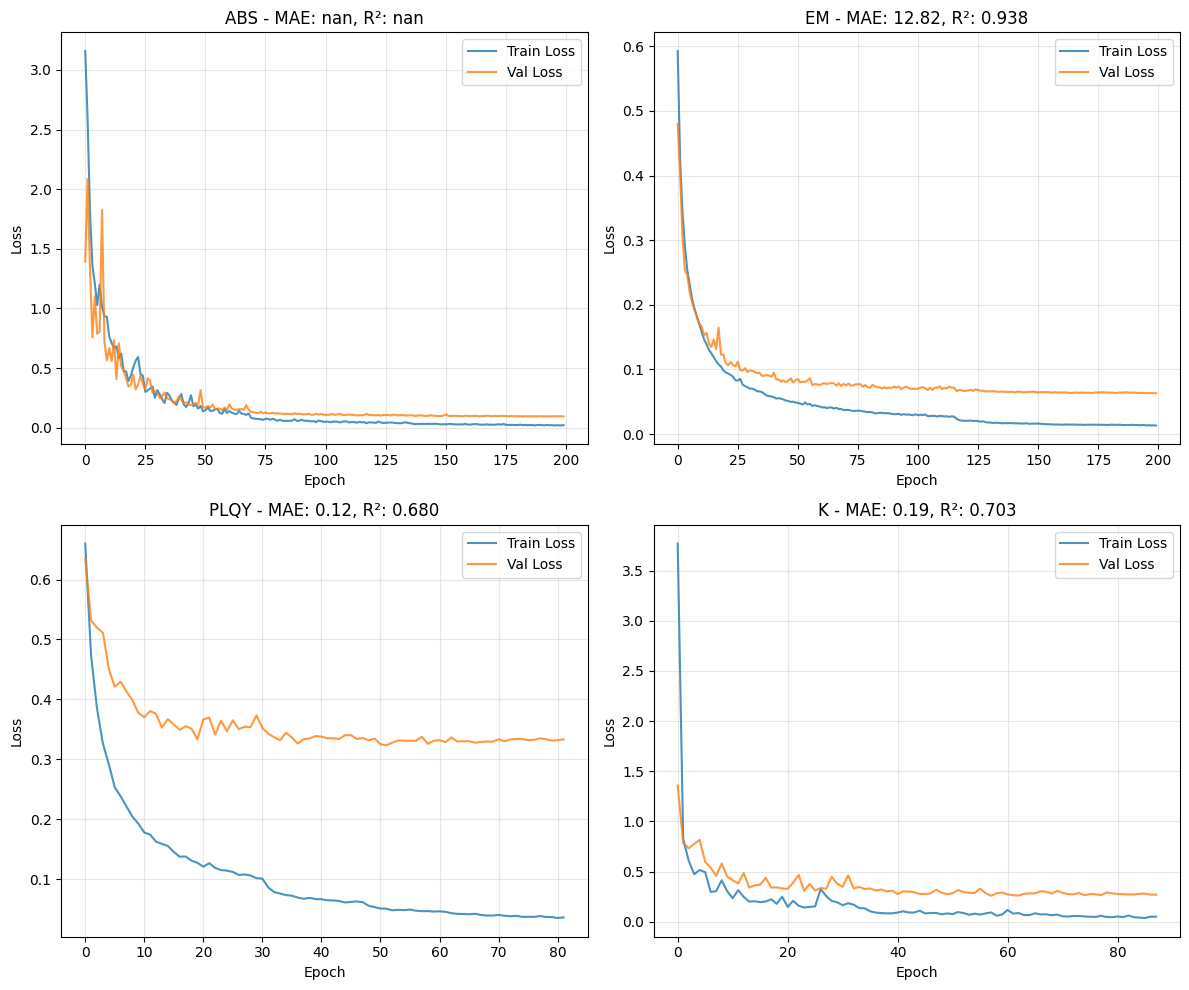

📊 Plot saved to: /content/drive/MyDrive/fluor_models/training_history.png


In [23]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, r in enumerate(results):
    if idx >= 4:
        break
    ax = axes[idx]
    ax.plot(r['history']['train_loss'], label='Train Loss', alpha=0.8)
    ax.plot(r['history']['val_loss'], label='Val Loss', alpha=0.8)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f"{r['target'].upper()} - MAE: {r['mae']:.2f}, R²: {r['r2']:.3f}")
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(results), 4):
    axes[idx].axis('off')

plt.tight_layout()

# Save to Google Drive
plot_path = os.path.join(DRIVE_OUTPUT, 'training_history.png')
plt.savefig(plot_path, dpi=150)
plt.show()
print(f"📊 Plot saved to: {plot_path}")

## 11. Make Predictions

Use the trained models to predict properties for new molecules.

In [24]:
# ============================================================================
# Prediction Input - Define molecules to test
# ============================================================================

# List of (name, SMILES) tuples - add as many as you want!
molecules = [
    ("BODIPY-phenyl", "C2=C1C7=C(C(=[N+]1[B-]([N]3C2=C5C(=C3C4=CC=CC=C4)C=CC=C5)(F)F)C6=CC=CC=C6)C=CC=C7"),
    ("BODIPY-thiophene", "C2(=C1C(=C(C(=[N+]1[B-]([N]3C2=C(C(=C3C)C4=CC=CS4)C)(F)F)C)C5=CC=CS5)C)C6=C(C=C(C=C6C)C)C"),
]

# Solvent (same for all molecules)
solvent = "CC1=CC=CC=C1"  # toluene

print(f"🧫 Solvent: {solvent}")
print(f"\n🧪 Molecules to predict ({len(molecules)}):")
for name, smiles in molecules:
    print(f"   • {name}: {smiles[:50]}{'...' if len(smiles) > 50 else ''}")

🧪 Molecule: C2=C1C7=C(C(=[N+]1[B-]([N]3C2=C5C(=C3C4=CC=CC=C4)C=CC=C5)(F)F)C6=CC=CC=C6)C=CC=C7
🧫 Solvent:  CC1=CC=CC=C1


In [25]:
# ============================================================================
# Run Prediction
# ============================================================================
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def predict_properties(molecule_smiles, solvent_smiles, model_dir='./models', 
                       checkpoint_dir='/content/drive/MyDrive/fluor_checkpoints', device='cuda'):
    """Predict all properties for a single molecule with proper preprocessing and inverse scaling.
    
    This function mimics the preprocessing from 02_property_prediction.py.
    Uses MODEL_CONFIGS which matches ORIGINAL_MODEL_CONFIGS for consistency.
    """
    
    # Generate molecular graph
    graph = smiles_to_graph(molecule_smiles)
    if graph is None:
        raise ValueError(f"Could not parse molecule SMILES: {molecule_smiles}")
    
    mol = Chem.MolFromSmiles(molecule_smiles)
    sol = Chem.MolFromSmiles(solvent_smiles)
    if mol is None or sol is None:
        raise ValueError("Invalid SMILES")
    
    # Generate Morgan fingerprints (1024-bit, radius 2)
    mol_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    sol_fp = AllChem.GetMorganFingerprintAsBitVect(sol, radius=2, nBits=1024)
    mol_fp_arr = np.array(mol_fp, dtype=np.float32)
    sol_fp_arr = np.array(sol_fp, dtype=np.float32)
    
    # Compute molecular descriptors
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    double_bonds = sum(1 for bond in mol.GetBonds() 
                       if bond.GetBondType() == Chem.BondType.DOUBLE or bond.GetIsAromatic())
    ring_count = mol.GetRingInfo().NumRings()
    
    # Get solvent_num from mapping (simplified)
    solvent_mapping = {
        'CC1=CC=CC=C1': 6, 'Cc1ccccc1': 6,  # toluene
        'CCO': 2, 'CO': 1, 'c1ccccc1': 5,
    }
    solvent_num = solvent_mapping.get(solvent_smiles, 0)
    
    # Detect scaffold (simplified - check for BODIPY)
    bodipy_smarts = '[#5](-F)(-F)(-[#7])(-[#7])'
    tag = 0
    bodipy_pattern = Chem.MolFromSmarts(bodipy_smarts)
    if bodipy_pattern and mol.HasSubstructMatch(bodipy_pattern):
        tag = 5  # BODIPY
    
    # Create 136 scaffold flags
    scaffold_flags = np.zeros(136, dtype=np.float32)
    if tag == 5:  # BODIPY
        scaffold_flags[3] = 1  # fragment_4
    
    unimol_plus = 3.49  # placeholder
    
    # Numeric features: [solvent_num, tag, MW, LogP, TPSA, double_bonds, ring_count, unimol_plus]
    numeric_feats = np.array([solvent_num, tag, mw, logp, tpsa, double_bonds, ring_count, unimol_plus], dtype=np.float32)
    
    predictions = {}
    n_feats = graph.ndata['hv'].shape[1]
    e_feats = graph.edata['he'].shape[1]
    
    for target in ['abs', 'em', 'plqy', 'k']:
        model_path = os.path.join(model_dir, f'Model_{target}.pth')
        if not os.path.exists(model_path):
            print(f"   ⚠️ Model not found: {model_path}")
            continue
        
        # Load scaler parameters from checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{target}.pth')
        scaler_mean = None
        scaler_scale = None
        num_scaler_min = None
        num_scaler_scale = None
        
        if os.path.exists(checkpoint_path):
            ckpt = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
            scaler_mean = ckpt.get('scaler_mean', [0])[0]
            scaler_scale = ckpt.get('scaler_scale', [1])[0]
            # Load numeric scaler if saved
            num_scaler_min = ckpt.get('num_scaler_min', None)
            num_scaler_scale = ckpt.get('num_scaler_scale', None)
        
        # Apply numeric scaling if available, otherwise use raw values
        if num_scaler_min is not None and num_scaler_scale is not None:
            numeric_scaled = (numeric_feats - np.array(num_scaler_min)) / np.array(num_scaler_scale)
        else:
            # Fallback: use MinMaxScaler from training data
            train_path = os.path.join(DATA_DIR, f'train_{target}.csv')
            if os.path.exists(train_path):
                train_df = pd.read_csv(train_path)
                train_numeric = train_df.iloc[:, 8:16].values
                num_scaler = MinMaxScaler()
                num_scaler.fit(train_numeric)
                numeric_scaled = num_scaler.transform(numeric_feats.reshape(1, -1)).flatten()
            else:
                numeric_scaled = numeric_feats  # no scaling if no data
        
        # Combine extra features
        extra_feats = np.concatenate([numeric_scaled, scaffold_flags]).astype(np.float32)
        
        config = MODEL_CONFIGS[target]
        model_class = config['model_class']
        
        # Build fingerprint tensor: [solvent_fp(1024), smiles_fp(1024), extra(144)] = 2192
        fp = np.concatenate([sol_fp_arr, mol_fp_arr, extra_feats])
        
        if model_class == 'GraphFingerprintsModel':
            # abs/em use CNN attention architecture
            solvent_dim = 1024
            smiles_extra_dim = len(fp) - solvent_dim  # 1024 + 144 = 1168
            
            model = GraphFingerprintsModel(
                node_feat_size=n_feats,
                edge_feat_size=e_feats,
                solvent_dim=solvent_dim,
                smiles_extra_dim=smiles_extra_dim,
                graph_feat_size=GRAPH_FEAT_SIZE,
                num_layers=config['num_layers'],
                num_timesteps=config['num_timesteps'],
                n_tasks=1,
                dropout=config['dropout']
            )
        else:
            # plqy/k use simple FC architecture
            model = GraphFingerprintsModelFC(
                node_feat_size=n_feats,
                edge_feat_size=e_feats,
                fp_size=len(fp),  # 2192
                graph_feat_size=GRAPH_FEAT_SIZE,
                num_layers=config['num_layers'],
                num_timesteps=config['num_timesteps'],
                n_tasks=1,
                dropout=config['dropout']
            )
        
        # Load weights
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        model = model.to(device)
        model.eval()
        
        # Prepare inputs
        graph_batch = dgl.batch([graph]).to(device)
        node_feats = graph_batch.ndata['hv']
        edge_feats = graph_batch.edata['he']
        fp_tensor = torch.tensor(fp, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Predict
        with torch.no_grad():
            pred = model(graph_batch, node_feats, edge_feats, fp_tensor)
            pred_scaled = pred.item()
        
        # Inverse transform: original = scaled * scale + mean
        if scaler_mean is not None and scaler_scale is not None:
            pred_value = pred_scaled * scaler_scale + scaler_mean
        else:
            pred_value = pred_scaled
        
        predictions[target] = pred_value
    
    return predictions

# Run predictions for all molecules
print("\n🔮 Running predictions...")
all_results = []

for name, smiles in molecules:
    try:
        preds = predict_properties(smiles, solvent, model_dir=OUTPUT_DIR, 
                                   checkpoint_dir=CHECKPOINT_DIR, device=device)
        preds['name'] = name
        preds['smiles'] = smiles
        all_results.append(preds)
    except Exception as e:
        print(f"   ⚠️ Failed for {name}: {e}")

# Display results
print("\n" + "="*80)
print("📊 PREDICTION RESULTS")
print("="*80)

for preds in all_results:
    print(f"\n🧪 {preds['name']}")
    print(f"   SMILES: {preds['smiles'][:60]}{'...' if len(preds['smiles']) > 60 else ''}")
    print(f"   ─────────────────────────────────────")
    print(f"   Absorption (abs):     {preds.get('abs', 'N/A'):>7.1f} nm")
    print(f"   Emission (em):        {preds.get('em', 'N/A'):>7.1f} nm")
    print(f"   Quantum Yield (plqy): {preds.get('plqy', 'N/A'):>7.3f}")
    print(f"   Log ε (k):            {preds.get('k', 'N/A'):>7.2f}")

print("\n" + "="*80)

# Also create a summary DataFrame
import pandas as pd
results_df = pd.DataFrame(all_results)[['name', 'abs', 'em', 'plqy', 'k']]
results_df.columns = ['Molecule', 'Abs (nm)', 'Em (nm)', 'PLQY', 'Log ε']
print("\n📋 Summary Table:")
display(results_df)


🔮 Running predictions...

📊 PREDICTION RESULTS
   Absorption (abs):    637.6 nm
   Emission (em):       662.4 nm
   Quantum Yield (plqy): 0.861
   Log ε (k):           5.16


In [26]:
# ============================================================================
# Compare Old (Pretrained) vs New (Just Trained) Models
# ============================================================================
# 
# IMPORTANT: The original models require the FULL preprocessing pipeline:
# 1. Solvent mapping (solvent SMILES -> solvent_num via 00_solvent_mapping.csv)
# 2. Scaffold detection (match against 136 substructures)
# 3. MinMaxScaler normalization on 8 numeric features (fit on training data)
# 4. Scaler inverse transform on predictions
#
# For a quick comparison, we'll load the preprocessed input.csv that was 
# generated by the original pipeline.

OLD_MODEL_DIR = './fluor_tools/Fluor-RLAT'  # Original pretrained models from repo
NEW_MODEL_DIR = './models'  # Newly trained models
ORIGINAL_DATA_DIR = './fluor_tools/Fluor-RLAT/data'  # Training data for scalers

def predict_with_original_model_proper(molecule_smiles, solvent_smiles, model_dir, data_dir, device='cuda'):
    """Predict using original pretrained models with proper preprocessing.
    
    This function mimics the original 02_property_prediction.py pipeline.
    Uses ORIGINAL_MODEL_CONFIGS which matches the pretrained model architectures.
    """
    from rdkit import Chem
    from rdkit.Chem import AllChem, Descriptors
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    # Step 1: Create molecular graph
    graph = smiles_to_graph(molecule_smiles)
    if graph is None:
        raise ValueError(f"Could not parse molecule SMILES: {molecule_smiles}")
    
    mol = Chem.MolFromSmiles(molecule_smiles)
    sol = Chem.MolFromSmiles(solvent_smiles)
    if mol is None or sol is None:
        raise ValueError("Invalid SMILES")
    
    # Step 2: Generate Morgan fingerprints (1024-bit, radius 2)
    mol_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    sol_fp = AllChem.GetMorganFingerprintAsBitVect(sol, radius=2, nBits=1024)
    mol_fp_arr = np.array(mol_fp, dtype=np.float32)
    sol_fp_arr = np.array(sol_fp, dtype=np.float32)
    
    # Step 3: Compute molecular descriptors
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    double_bonds = sum(1 for bond in mol.GetBonds() 
                       if bond.GetBondType() == Chem.BondType.DOUBLE or bond.GetIsAromatic())
    ring_count = mol.GetRingInfo().NumRings()
    
    # Step 4: Get solvent_num from mapping (simplified - use 6 for toluene)
    solvent_mapping = {
        'CC1=CC=CC=C1': 6,  # toluene
        'Cc1ccccc1': 6,    # toluene (alternative)
        'CCO': 2,          # ethanol
        'CO': 1,           # methanol
        'c1ccccc1': 5,     # benzene
    }
    solvent_num = solvent_mapping.get(solvent_smiles, 0)
    
    # Step 5: Detect scaffold (simplified - check for BODIPY)
    bodipy_smarts = '[#5](-F)(-F)(-[#7])(-[#7])'
    tag = 0
    tag_name = 'Unknown'
    bodipy_pattern = Chem.MolFromSmarts(bodipy_smarts)
    if bodipy_pattern and mol.HasSubstructMatch(bodipy_pattern):
        tag = 5  # BODIPY tag
        tag_name = 'BODIPY'
    
    # Step 6: Create 136 scaffold flags (simplified - just set fragment_4 for BODIPY)
    scaffold_flags = np.zeros(136, dtype=np.float32)
    if tag == 5:  # BODIPY
        scaffold_flags[3] = 1  # fragment_4 (0-indexed as 3)
    
    # Step 7: Get unimol_plus placeholder
    unimol_plus = 3.49  # placeholder
    
    # Numeric features in correct order: [solvent_num, tag, MW, LogP, TPSA, double_bonds, ring_count, unimol_plus]
    numeric_feats = np.array([solvent_num, tag, mw, logp, tpsa, double_bonds, ring_count, unimol_plus], dtype=np.float32)
    
    predictions = {}
    raw_predictions = {}
    n_feats = graph.ndata['hv'].shape[1]
    e_feats = graph.edata['he'].shape[1]
    
    for target in ['abs', 'em', 'plqy', 'k']:
        model_path = os.path.join(model_dir, f'Model_{target}.pth')
        if not os.path.exists(model_path):
            continue
        
        # Load training data to fit scalers (same as original pipeline)
        train_path = os.path.join(data_dir, f'train_{target}.csv')
        if not os.path.exists(train_path):
            print(f"   ⚠️ Training data not found: {train_path}")
            continue
            
        train_df = pd.read_csv(train_path)
        
        # Fit label scaler
        label_scaler = StandardScaler()
        label_scaler.fit(train_df[[target]].values)
        
        # Fit numeric scaler on columns 8:16 of training data
        train_numeric = train_df.iloc[:, 8:16].values
        num_scaler = MinMaxScaler()
        num_scaler.fit(train_numeric)
        
        # Apply numeric scaler to our features
        numeric_scaled = num_scaler.transform(numeric_feats.reshape(1, -1)).flatten()
        
        # Combine extra features: scaled_numeric (8) + scaffold_flags (136) = 144
        extra_feats = np.concatenate([numeric_scaled, scaffold_flags]).astype(np.float32)
        
        config = ORIGINAL_MODEL_CONFIGS[target]
        model_class = config['model_class']
        
        # Build fingerprint tensor: [solvent_fp(1024), smiles_fp(1024), extra(144)] = 2192
        fp = np.concatenate([sol_fp_arr, mol_fp_arr, extra_feats])
        
        if model_class == 'GraphFingerprintsModel':
            # abs/em use CNN attention architecture
            solvent_dim = 1024
            smiles_extra_dim = len(fp) - solvent_dim  # 1024 + 144 = 1168
            
            model = GraphFingerprintsModel(
                node_feat_size=n_feats,
                edge_feat_size=e_feats,
                solvent_dim=solvent_dim,
                smiles_extra_dim=smiles_extra_dim,
                graph_feat_size=256,
                num_layers=config['num_layers'],
                num_timesteps=config['num_timesteps'],
                n_tasks=1,
                dropout=config['dropout']
            )
        else:
            # plqy/k use simple FC architecture
            model = GraphFingerprintsModelFC(
                node_feat_size=n_feats,
                edge_feat_size=e_feats,
                fp_size=len(fp),  # 2192
                graph_feat_size=256,
                num_layers=config['num_layers'],
                num_timesteps=config['num_timesteps'],
                n_tasks=1,
                dropout=config['dropout']
            )
        
        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        model = model.to(device)
        model.eval()
        
        graph_batch = dgl.batch([graph]).to(device)
        node_feats = graph_batch.ndata['hv']
        edge_feats = graph_batch.edata['he']
        fp_tensor = torch.tensor(fp, dtype=torch.float32).unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred = model(graph_batch, node_feats, edge_feats, fp_tensor)
            raw_pred = pred.item()
            raw_predictions[target] = raw_pred
            
            # Inverse transform using label scaler
            pred_value = label_scaler.inverse_transform([[raw_pred]])[0, 0]
            predictions[target] = pred_value
    
    return predictions, raw_predictions


print("🔬 Comparing pretrained vs newly trained models\n")
print(f"Molecule: {molecule}")
print(f"Solvent:  {solvent}\n")

# Check which models exist
old_models_exist = all(os.path.exists(os.path.join(OLD_MODEL_DIR, f'Model_{t}.pth')) for t in ['abs', 'em', 'plqy', 'k'])
new_models_exist = all(os.path.exists(os.path.join(NEW_MODEL_DIR, f'Model_{t}.pth')) for t in ['abs', 'em', 'plqy', 'k'])

print(f"Old models found: {'✅' if old_models_exist else '❌'} ({OLD_MODEL_DIR})")
print(f"New models found: {'✅' if new_models_exist else '❌'} ({NEW_MODEL_DIR})")

old_preds = {}
old_raw = {}
new_preds = {}

if old_models_exist:
    print("\n🔮 Running predictions with original pretrained models...")
    try:
        old_preds, old_raw = predict_with_original_model_proper(
            molecule, solvent, 
            model_dir=OLD_MODEL_DIR, 
            data_dir=ORIGINAL_DATA_DIR,
            device=device
        )
        print("   ✅ Original model predictions complete")
        print(f"   Raw outputs (normalized): abs={old_raw.get('abs', 'N/A'):.3f}, em={old_raw.get('em', 'N/A'):.3f}, plqy={old_raw.get('plqy', 'N/A'):.3f}, k={old_raw.get('k', 'N/A'):.3f}")
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()

if new_models_exist:
    print("\n🔮 Running predictions with newly trained models...")
    try:
        new_preds = predict_properties(molecule, solvent, model_dir=NEW_MODEL_DIR, 
                                       checkpoint_dir=CHECKPOINT_DIR, device=device)
        print("   ✅ New model predictions complete")
    except Exception as e:
        print(f"   ❌ Error: {e}")
        import traceback
        traceback.print_exc()

# Display comparison
if old_preds or new_preds:
    print("\n" + "="*70)
    print("📊 MODEL COMPARISON")
    print("="*70)
    print(f"{'Property':<20} {'Original':<18} {'Retrained':<18} {'Diff':<12}")
    print("-"*70)
    
    # Expected values from running the original pipeline
    expected = {'abs': 639.89, 'em': 660.38, 'plqy': 0.76, 'k': 5.0}
    
    for prop, unit, fmt in [('abs', 'nm', '.1f'), ('em', 'nm', '.1f'), ('plqy', '', '.3f'), ('k', '', '.2f')]:
        old_val = old_preds.get(prop, float('nan'))
        new_val = new_preds.get(prop, float('nan'))
        exp_val = expected.get(prop, float('nan'))
        
        old_str = f"{old_val:{fmt}} {unit}".strip() if not np.isnan(old_val) else "N/A"
        new_str = f"{new_val:{fmt}} {unit}".strip() if not np.isnan(new_val) else "N/A"
        
        if not np.isnan(old_val) and not np.isnan(new_val):
            diff = new_val - old_val
            diff_str = f"{diff:+{fmt}}"
        else:
            diff_str = "-"
        
        prop_name = {'abs': 'Absorption', 'em': 'Emission', 'plqy': 'Quantum Yield', 'k': 'Log ε'}[prop]
        print(f"   {prop_name:<17} {old_str:<18} {new_str:<18} {diff_str:<12}")
    
    
    print("="*70)
    
    # Show expected from original pipeline
    print("\n📋 Reference values from original pipeline (run.py):")
    print(f"   Absorption:    {expected['abs']:.2f} nm")
    print(f"   Emission:      {expected['em']:.2f} nm")
    print(f"   Quantum Yield: {expected['plqy']:.2f}")
    print(f"   Log ε:         {expected['k']:.1f}")
    
    print("\n📏 Expected value ranges:")
    print("   Absorption:    ~300-900 nm")
    print("   Emission:      ~350-1000 nm")
    print("   Quantum Yield: 0.0-1.0")
    print("   Log ε:         ~3.0-5.5")

🔬 Comparing pretrained vs newly trained models

Molecule: C2=C1C7=C(C(=[N+]1[B-]([N]3C2=C5C(=C3C4=CC=CC=C4)C=CC=C5)(F)F)C6=CC=CC=C6)C=CC=C7
Solvent:  CC1=CC=CC=C1

Old models found: ✅ (./fluor_tools/Fluor-RLAT)
New models found: ✅ (./models)

🔮 Running predictions with original pretrained models...
   ✅ Original model predictions complete
   Raw outputs (normalized): abs=1.722, em=1.425, plqy=1.221, k=0.927

🔮 Running predictions with newly trained models...
   ✅ New model predictions complete

📊 MODEL COMPARISON
Property             Original           Retrained          Diff        
----------------------------------------------------------------------
   Absorption        637.6 nm           637.6 nm           +0.0        
   Emission          656.5 nm           662.4 nm           +5.9        
   Quantum Yield     0.742              0.861              +0.119      
   Log ε             5.00               5.16               +0.16       

📋 Reference values from original pipeline (run.py

## 13. Batch Comparison: Old vs Retrained Models vs Experimental Data

Load experimental measurements from `Daten_clean.csv` and compare predictions from both the original pretrained and newly retrained models against ground truth. Each subplot shows one property (abs, em, plqy, k) as a parity plot.

📂 Loaded 126 rows from Daten_clean.csv
📊 After filtering: 115 molecules
   abs: 115, em: 113, plqy: 10, ε→log_ε: 75
Invalid mol found

✅ Predicted 114 molecules, 1 failed
   abs: 114 data points
   em: 112 data points
   plqy: 10 data points
   k: 74 data points

⚠️ First error:
BJ3185 (CC(C)(C)c1cc(cc2OB(F)(F)N(=Cc21)/C=C/N1=): Could not create graph for: CC(C)(C)c1cc(cc2OB(F)(F)N(=Cc21)/C=C/N1=Cc2c(OB1(F)F)cc(cc2C(C)(C)C)C(C)(C)C)C(C)(C)C
Traceback (most recent call last):
  File "/tmp/ipython-input-941902106.py", line 174, in <cell line: 0>
    old_p = _predict_single(smiles, sol_smiles,
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-941902106.py", line 25, in _predict_single
    raise ValueError(f"Could not create graph for: {molecule_smiles}")
ValueError: Could not create graph for: CC(C)(C)c1cc(cc2OB(F)(F)N(=Cc21)/C=C/N1=Cc2c(OB1(F)F)cc(cc2C(C)(C)C)C(C)(C)C)C(C)(C)C



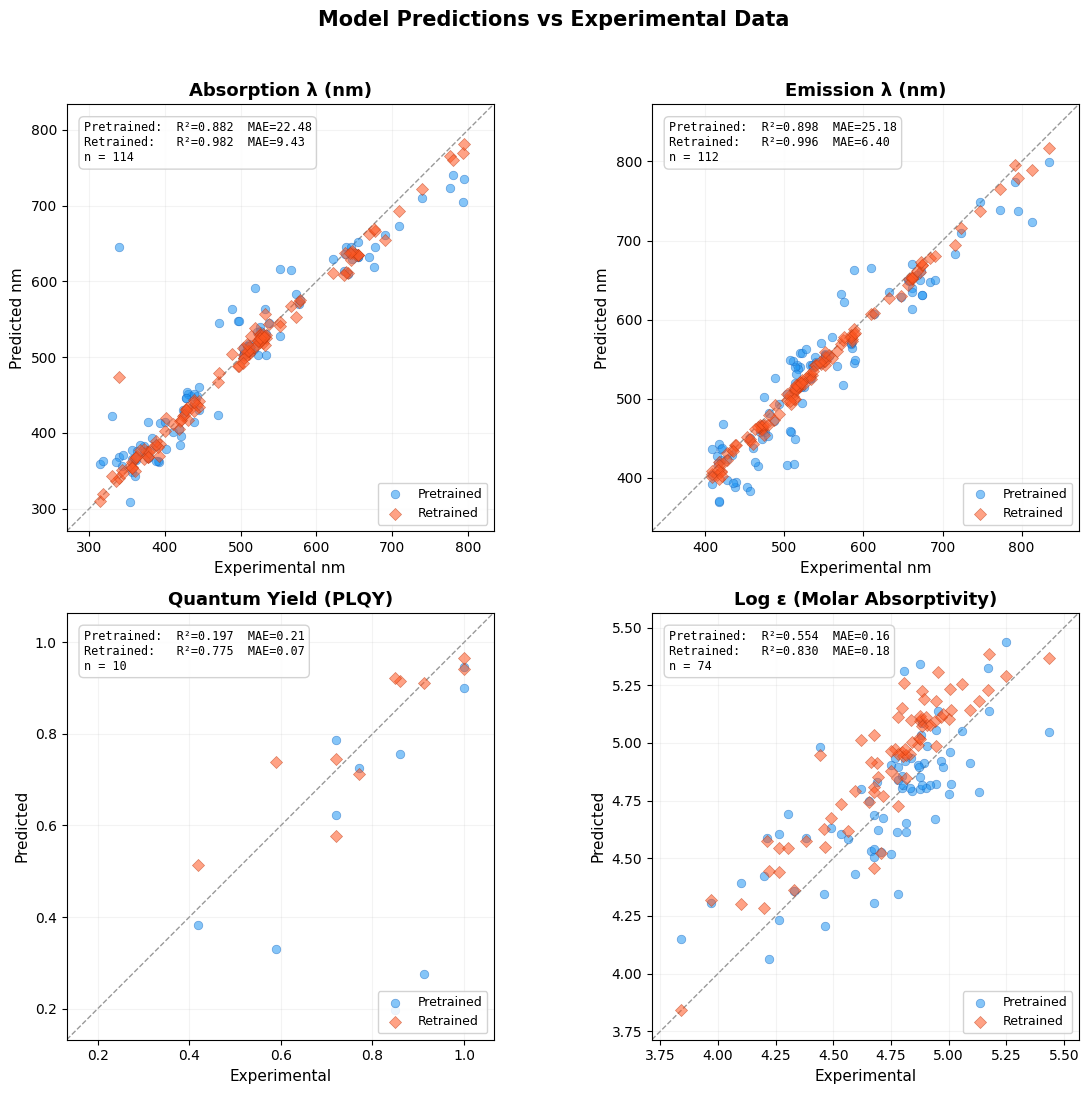


💾 Saved to: /content/drive/MyDrive/fluor_models/model_comparison_experimental.png


In [ ]:
# ============================================================================
# Batch Comparison: Old vs Retrained vs Experimental
# ============================================================================
import matplotlib.pyplot as plt
from scipy import stats
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import traceback
import warnings
warnings.filterwarnings('ignore')

# --- 0. Load full preprocessing resources (once) ---
# Solvent mapping: SMILES -> solvent_num
_solvent_map_df = pd.read_csv(os.path.join(DATA_DIR, '00_solvent_mapping.csv'))
_SOLVENT_MAP = dict(zip(_solvent_map_df['solvent'], _solvent_map_df['solvent_num']))
print(f"   Loaded {len(_SOLVENT_MAP)} solvent mappings")

# MMP substructure patterns: 136 SMARTS -> RDKit Mol objects
_sub_df = pd.read_csv(os.path.join(DATA_DIR, '00_mmp_substructure.csv'))
_SUBSTRUCTURE_MOLS = [Chem.MolFromSmarts(s) for s in _sub_df['fragment']]
print(f"   Loaded {len(_SUBSTRUCTURE_MOLS)} substructure patterns")

# Scaffold definitions (from 01_data_preprocessing.py)
try:
    from FLAME.flsf.scaffold import scaffold as _scaffold_dict
except ImportError:
    _scaffold_dict = {
        'SquaricAcid': ['O=c1ccc1=O','O=C1CC([O-])C1','O=C1C=C(O)C1','OC1=CCC1','C=c1c(=O)c(=C)c1=O','c1ccc(N2CCC2)cc1','C=C1C(C=C1)=O'],
        'Naphthalimide': ['O=C1NC(=O)c2cccc3cccc1c23','O=C(C1=C2C(C=CC=C23)=CC=C1)NC3=O'],
        'Coumarin': ['C1=Cc2ccccc2OC1','O=c1ccc2ccccc2o1','S=c1ccc2ccccc2o1','O=C1C=C(C)c2ccccc2C1(F)F','O=c1ccc2ccccc2[nH]1','C[Si]1(C)C(=O)C=Cc2ccccc21','N=c1ccc2ccccc2o1','O=c1cnc2ccccc2o1','O=c1cnc2ccccc2[nH]1'],
        'Carbazole': ['[nH]1c2ccccc2c3ccccc13'],
        'Cyanine': ['NC=CC=O','NC=CC=[OH+]','NC=CC=[NH2+]','NC=CC=CC=O','NC=CC=CC=[OH+]','NC=CC=CC=[NH2+]','NC=CC=CC=CC=O','NC=CC=CC=CC=[OH+]','NC=CC=CC=CC=[NH2+]','NC=CC=CC=CC=CC=O','NC=CC=CC=CC=CC=[OH+]','NC=CC=CC=CC=CC=[NH2+]'],
        'BODIPY': ['B(n1cccc1)n1cccc1','N1([BH2-]n2cccc2)C=CCC1','[BH2-](N1CC=CC1)n1cccc1','n1([BH2-][N+]2=CC=CC2)cccc1','[BH2-](n1cccc1)[N+]1=CC=CC1','[N+][BH2-][N+]','N[BH2-][N+]','N[BH2-]N','[N+]B[N+]','NB[N+]','NBN'],
        'Triphenylamine': ['c1ccc(cc1)N(c2ccccc2)c3ccccc3','C1=CC(=[N+](c2ccccc2)c2ccccc2)C=CC1'],
        'Porphyrin': ['C1=Cc2cc3ccc(cc4nc(cc5ccc(cc1n2)[nH]5)C=C4)[nH]3'],
        'PAHs': ['c1ccc2ccccc2c1','c1ccc2cc3ccccc3cc2c1','c1ccc2c(c1)ccc3ccccc23','c1cc2ccc3cccc4ccc(c1)c2c34','c1cc2cccc3c4cccc5cccc(c(c1)c23)c45','c1ccc2c(c1)ccc3ccc4ccc5ccccc5c4c23'],
        'Acridines': ['O=c1c2ccccc2oc2ccccc12','c1ccc2[o+]c3ccccc3cc2c1','c1ccc2c(c1)Cc1ccccc1O2','O=c1ccc2cc3ccccc3oc-2c1','N=c1ccc2cc3ccccc3[nH]c-2c1'],
        'Oxazines': [],
        'Thiazines': [],
        'Diketopyrrolopyrrole': [],
        'Phenoxazine': [],
        'Phenothiazine': [],
        'Benzothiadiazole': [],
    }

# Pre-compile scaffold patterns
_scaff_idx = dict([(k, v) for v, k in enumerate(_scaffold_dict.keys())])
_scaffold_patterns = []
for name, smiles_list in _scaffold_dict.items():
    for smi in smiles_list:
        m = Chem.MolFromSmiles(smi)
        if m:
            _scaffold_patterns.append((_scaff_idx[name], m))
print(f"   Loaded {len(_scaffold_patterns)} scaffold patterns across {len(_scaffold_dict)} classes")


def _predict_single(molecule_smiles, solvent_smiles, model_dir, data_dir,
                     model_configs, checkpoint_dir=None, device='cuda'):
    """Predict all 4 properties for one molecule using FULL preprocessing pipeline.
    
    Uses the same feature computation as 01_data_preprocessing.py:
    - Full solvent mapping from 00_solvent_mapping.csv
    - All 136 MMP substructure flags from 00_mmp_substructure.csv
    - Full scaffold tag detection (16 scaffold classes)
    """
    mol = Chem.MolFromSmiles(molecule_smiles)
    if mol is None:
        raise ValueError(f"RDKit cannot parse SMILES: {molecule_smiles}")
    canon_smiles = Chem.MolToSmiles(mol)

    graph = smiles_to_graph(canon_smiles)
    if graph is None:
        graph = smiles_to_graph(molecule_smiles)
    if graph is None:
        raise ValueError(f"Could not featurize graph for: {molecule_smiles}")

    sol = Chem.MolFromSmiles(solvent_smiles)
    if sol is None:
        raise ValueError(f"Invalid solvent SMILES: {solvent_smiles}")

    # --- Morgan fingerprints (1024-bit, radius 2) ---
    mol_fp = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024), dtype=np.float32)
    sol_fp = np.array(AllChem.GetMorganFingerprintAsBitVect(sol, radius=2, nBits=1024), dtype=np.float32)

    # --- Molecular descriptors (matches 01_data_preprocessing.py) ---
    mw = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    tpsa = Descriptors.TPSA(mol)
    double_bonds = sum(1 for b in mol.GetBonds()
                       if b.GetBondType() == Chem.BondType.DOUBLE or b.GetIsAromatic())
    ring_count = mol.GetRingInfo().NumRings()

    # --- Full solvent mapping ---
    solvent_num = _SOLVENT_MAP.get(solvent_smiles, -1)
    if solvent_num == -1:
        # Try canonical solvent SMILES
        canon_sol = Chem.MolToSmiles(sol)
        solvent_num = _SOLVENT_MAP.get(canon_sol, 0)

    # --- Full scaffold tag detection (16 classes) ---
    tag = -1
    for idx, pattern_mol in _scaffold_patterns:
        if mol.HasSubstructMatch(pattern_mol):
            tag = idx
            break

    # --- Full 136 MMP substructure flags ---
    scaffold_flags = np.zeros(136, dtype=np.float32)
    for i, sub_mol in enumerate(_SUBSTRUCTURE_MOLS):
        if sub_mol is not None and mol.HasSubstructMatch(sub_mol):
            scaffold_flags[i] = 1.0

    # --- unimol_plus placeholder (mean of training data) ---
    unimol_plus = 3.51

    numeric_feats = np.array([solvent_num, tag, mw, logp, tpsa, double_bonds,
                              ring_count, unimol_plus], dtype=np.float32)

    n_feats = graph.ndata['hv'].shape[1]
    e_feats = graph.edata['he'].shape[1]
    predictions = {}

    for target in ['abs', 'em', 'plqy', 'k']:
        model_path = os.path.join(model_dir, f'Model_{target}.pth')
        if not os.path.exists(model_path):
            continue

        # --- Scalers ---
        train_path = os.path.join(data_dir, f'train_{target}.csv')
        if not os.path.exists(train_path):
            continue
        train_df = pd.read_csv(train_path)

        label_scaler = StandardScaler()
        label_scaler.fit(train_df[[target]].values)

        num_scaler = MinMaxScaler()
        num_scaler.fit(train_df.iloc[:, 8:16].values)

        # If checkpoint_dir provided, try to load saved scalers (for new models)
        if checkpoint_dir:
            ckpt_path = os.path.join(checkpoint_dir, f'checkpoint_{target}.pth')
            if os.path.exists(ckpt_path):
                ckpt = torch.load(ckpt_path, map_location='cpu', weights_only=False)
                sm = ckpt.get('scaler_mean')
                ss = ckpt.get('scaler_scale')
                if sm is not None and ss is not None:
                    label_scaler.mean_ = np.array(sm)
                    label_scaler.scale_ = np.array(ss)
                nsm = ckpt.get('num_scaler_min')
                nss = ckpt.get('num_scaler_scale')
                if nsm is not None and nss is not None:
                    num_scaler.min_ = np.array(nsm)
                    num_scaler.scale_ = np.array(nss)

        numeric_scaled = num_scaler.transform(numeric_feats.reshape(1, -1)).flatten()
        extra = np.concatenate([numeric_scaled, scaffold_flags]).astype(np.float32)
        fp = np.concatenate([sol_fp, mol_fp, extra])  # [1024+1024+144] = 2192

        config = model_configs[target]
        mc = config['model_class']

        if mc == 'GraphFingerprintsModel':
            model = GraphFingerprintsModel(
                node_feat_size=n_feats, edge_feat_size=e_feats,
                solvent_dim=1024, smiles_extra_dim=len(fp)-1024,
                graph_feat_size=256,
                num_layers=config['num_layers'],
                num_timesteps=config['num_timesteps'],
                n_tasks=1, dropout=config['dropout'])
        else:
            model = GraphFingerprintsModelFC(
                node_feat_size=n_feats, edge_feat_size=e_feats,
                fp_size=len(fp), graph_feat_size=256,
                num_layers=config['num_layers'],
                num_timesteps=config['num_timesteps'],
                n_tasks=1, dropout=config['dropout'])

        model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        model.to(device).eval()

        gb = dgl.batch([graph]).to(device)
        fp_t = torch.tensor(fp, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            raw = model(gb, gb.ndata['hv'], gb.edata['he'], fp_t).item()
        predictions[target] = label_scaler.inverse_transform([[raw]])[0, 0]

    return predictions


# --- 1. Load experimental data ---
CSV_PATH = '/content/drive/MyDrive/fluor_models/Daten_clean.csv'
exp_df = pd.read_csv(CSV_PATH)
print(f"📂 Loaded {len(exp_df)} rows from Daten_clean.csv")

SOLVENT_NAME_TO_SMILES = {
    'Toluol': 'Cc1ccccc1', 'Methanol': 'CO', 'MeOH': 'CO',
    'Chloroform': 'ClC(Cl)Cl', 'DCM': 'ClCCl', 'THF': 'C1CCOC1',
}

exp_df = exp_df[exp_df['solvent'].isin(SOLVENT_NAME_TO_SMILES.keys())].copy()
exp_df['solvent_smiles'] = exp_df['solvent'].map(SOLVENT_NAME_TO_SMILES)
exp_df['log_epsilon'] = np.where(
    exp_df['epsilon'].notna() & (exp_df['epsilon'] > 0),
    np.log10(exp_df['epsilon']), np.nan)

print(f"📊 After filtering: {len(exp_df)} molecules")
print(f"   abs: {exp_df['abs'].notna().sum()}, em: {exp_df['em'].notna().sum()}, "
      f"plqy: {exp_df['plqy'].notna().sum()}, ε→log_ε: {exp_df['log_epsilon'].notna().sum()}")

# --- 2. Run predictions ---
OLD_MODEL_DIR = './fluor_tools/Fluor-RLAT'
NEW_MODEL_DIR = './models'
ORIGINAL_DATA_DIR = './fluor_tools/Fluor-RLAT/data'

EXP_COL = {'abs': 'abs', 'em': 'em', 'plqy': 'plqy', 'k': 'log_epsilon'}

old_preds = {t: [] for t in ['abs', 'em', 'plqy', 'k']}
new_preds = {t: [] for t in ['abs', 'em', 'plqy', 'k']}
exp_vals  = {t: [] for t in ['abs', 'em', 'plqy', 'k']}

n_success = 0
n_fail = 0
n_skip = 0
skipped_names = []
first_error = None

for idx, row in exp_df.iterrows():
    smiles = row['smiles']
    sol_smiles = row['solvent_smiles']

    try:
        old_p = _predict_single(smiles, sol_smiles,
                                model_dir=OLD_MODEL_DIR, data_dir=ORIGINAL_DATA_DIR,
                                model_configs=ORIGINAL_MODEL_CONFIGS, device=device)
        new_p = _predict_single(smiles, sol_smiles,
                                model_dir=NEW_MODEL_DIR, data_dir=DATA_DIR,
                                model_configs=MODEL_CONFIGS,
                                checkpoint_dir=CHECKPOINT_DIR, device=device)
        n_success += 1
    except ValueError:
        # Molecule can't be parsed/featurized — skip silently
        n_skip += 1
        skipped_names.append(row['name'])
        continue
    except Exception as exc:
        n_fail += 1
        if first_error is None:
            first_error = f"{row['name']}: {exc}\n{traceback.format_exc()}"
        continue

    for target in ['abs', 'em', 'plqy', 'k']:
        exp_v = row.get(EXP_COL[target])
        if pd.notna(exp_v) and target in old_p and target in new_p:
            exp_vals[target].append(float(exp_v))
            old_preds[target].append(old_p[target])
            new_preds[target].append(new_p[target])

print(f"\n✅ Predicted {n_success} molecules, {n_skip} skipped (unparseable), {n_fail} errors")
for t in ['abs', 'em', 'plqy', 'k']:
    print(f"   {t}: {len(exp_vals[t])} data points")

if skipped_names:
    print(f"\n⏭️  Skipped: {', '.join(skipped_names)}")

if first_error:
    print(f"\n⚠️ First error:\n{first_error}")

# --- 3. Plot ---
PROP_LABELS = {
    'abs':  ('Absorption λ (nm)', 'nm'),
    'em':   ('Emission λ (nm)', 'nm'),
    'plqy': ('Quantum Yield (PLQY)', ''),
    'k':    ('Log ε (Molar Absorptivity)', ''),
}

fig, axes = plt.subplots(2, 2, figsize=(12, 11))
axes = axes.flatten()

for i, target in enumerate(['abs', 'em', 'plqy', 'k']):
    ax = axes[i]
    label, unit = PROP_LABELS[target]

    e = np.array(exp_vals[target])
    o = np.array(old_preds[target])
    n = np.array(new_preds[target])

    if len(e) < 2:
        ax.text(0.5, 0.5, f'{label}\nInsufficient data', ha='center', va='center',
                transform=ax.transAxes, fontsize=13)
        ax.set_title(label, fontsize=13, fontweight='bold')
        continue

    ax.scatter(e, o, s=38, alpha=0.55, c='#2196F3', edgecolors='#1565C0',
               linewidths=0.5, label='Pretrained', zorder=3)
    ax.scatter(e, n, s=38, alpha=0.55, c='#FF5722', edgecolors='#BF360C',
               linewidths=0.5, label='Retrained', marker='D', zorder=4)

    all_vals = np.concatenate([e, o, n])
    lo, hi = np.nanmin(all_vals), np.nanmax(all_vals)
    margin = (hi - lo) * 0.08
    lo -= margin; hi += margin
    ax.plot([lo, hi], [lo, hi], 'k--', alpha=0.4, lw=1, zorder=1)
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    ax.set_aspect('equal', adjustable='box')

    r2_old = stats.pearsonr(e, o)[0] ** 2
    mae_old = np.mean(np.abs(e - o))
    r2_new = stats.pearsonr(e, n)[0] ** 2
    mae_new = np.mean(np.abs(e - n))

    stats_text = (f"Pretrained:  R²={r2_old:.3f}  MAE={mae_old:.2f}\n"
                  f"Retrained:   R²={r2_new:.3f}  MAE={mae_new:.2f}\n"
                  f"n = {len(e)}")
    ax.text(0.04, 0.96, stats_text, transform=ax.transAxes,
            fontsize=8.5, verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.85, edgecolor='#ccc'))

    ax.set_xlabel(f'Experimental {unit}'.strip(), fontsize=11)
    ax.set_ylabel(f'Predicted {unit}'.strip(), fontsize=11)
    ax.set_title(label, fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9, framealpha=0.85)
    ax.grid(True, alpha=0.15)

fig.suptitle('Model Predictions vs Experimental Data', fontsize=15, fontweight='bold', y=0.99)
plt.tight_layout(rect=[0, 0, 1, 0.97])

plot_path = '/content/drive/MyDrive/fluor_models/model_comparison_experimental.png'
plt.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.show()
print(f"\n💾 Saved to: {plot_path}")